In [1]:
# ownerpath = f'/Users/lenfn/Documents/AST 443/AST 443 Group 5'

In [2]:
# ownerpath = f'/Users/mia/Desktop/AST443 Observational Techniques in Astronomy'

In [3]:
ownerpath = f'/content/drive/MyDrive/AST 443 Group 5'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
from matplotlib import pyplot as plt
from matplotlib import colors
from astropy.io import fits
from IPython.display import Image
import math
import numpy as np
#import sep

import glob
import matplotlib.colors as colors
from astropy.io import ascii
from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans
from astropy.visualization import make_lupton_rgb
from astropy.table import Table
#from astroquery.astrometry_net import AstrometryNet
from astropy.stats import sigma_clipped_stats
from astropy.modeling import models
from astropy.modeling.models import BlackBody
from astropy import units as u

#from photutils.datasets import load_star_image
#from photutils.detection import DAOStarFinder
#from photutils.aperture import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization import simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
#AstrometryNet.key = 'kwbavttkhitkoaeo'

%matplotlib inline

from scipy import stats
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from astropy.io import fits
from scipy.ndimage import shift
#from specutils.spectra import Spectrum1D, SpectralRegion
#from specutils.fitting import fit_generic_continuum

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Mercury Frames

In [6]:
#Open the mercury frame files and extract the data
raw_mercury=[]

for i in range(2):
    mercury_file = f'{ownerpath}/Lab 3/20tau/mercury_arc_lamp/mercury_light_120s_.0000000{i}.FIT'
    mercury_file_data=fits.open(mercury_file)
    raw_mercury.append(mercury_file_data[0].data)

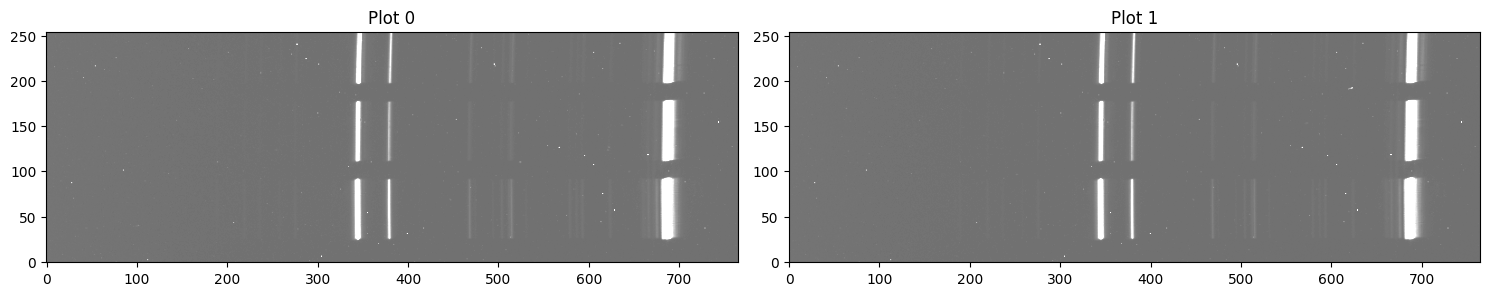

In [7]:
# All mercury frames
fig, axes = plt.subplots(1, 2, figsize=(15, 10))  # 2 rows, 5 columns grid for 10 plots
axes = axes.ravel()  # Flatten the 2D array of axes to make indexing easier

for i in range(2):  # Loop through the 3 indices
    axes[i].imshow(raw_mercury[i],
                   vmin=np.mean(raw_mercury[i]) - np.std(raw_mercury[i]),
                   vmax=np.mean(raw_mercury[i]) + np.std(raw_mercury[i]),
                   cmap='gray', origin='lower')
    axes[i].set_title(f"Plot {i}")  # Optionally, label each subplot
    #axes[i].axis('off')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# Cropping Mercury frames

In [8]:
# List to hold the cut data of each mercury frame
raw_mercury_cut = []

# Define the y-axis ranges for each frame
y_ranges_raw_hg = [(24, 94), (24, 94)]

# Loop through each corrected frame, cut along y-axis, and extract the data
for i in range(2):
    # Get the full frame data
    mercury_data = raw_mercury[i]

    # Cut the frame data along the y-axis according to the specified range
    hgy_start, hgy_end = y_ranges_raw_hg[i]
    cut_mercury_data = mercury_data[hgy_start:hgy_end, :]

    # Append the cut frame data to the list
    raw_mercury_cut.append(cut_mercury_data)

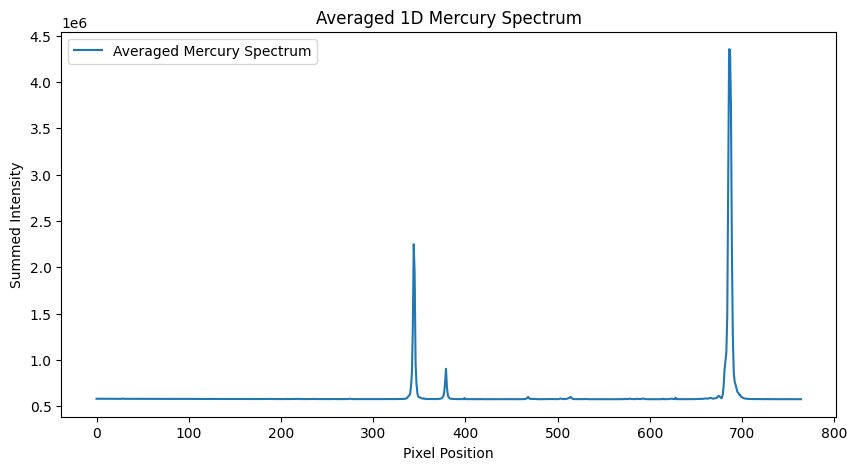

In [9]:
# Step 1: Sum along the y-axis for each mercury frame
summed_mercury = []

for frame in raw_mercury_cut:
    summed_1d = frame.sum(axis=0)  # Sum along the y-axis
    summed_mercury.append(summed_1d)

# Step 2: Average the summed mercury spectra across the frames
average_mercury_spectrum = np.mean(summed_mercury, axis=0)

# Step 3: Plot the averaged mercury spectrum
plt.figure(figsize=(10, 5))
plt.plot(average_mercury_spectrum, label="Averaged Mercury Spectrum")
plt.title("Averaged 1D Mercury Spectrum")
plt.xlabel("Pixel Position")
plt.ylabel("Summed Intensity")
plt.legend()
plt.show()

# Calibrating Pixel Position into Wavelength in nm

In [10]:
#Wavelengths of identified Mercury lines
#from https://www.newport.com/medias/sys_master/images/images/h55/hfd/8797293281310/Typical-to.pdf

identified_hg_lines = {
    "Hg 435.86 nm": 435.86,
    "Hg 407.78 nm": 407.78,
    "Hg 404.66 nm": 404.66
}

hg_wavelength=sorted(identified_hg_lines.values())
hg_dict=sorted(identified_hg_lines.keys())

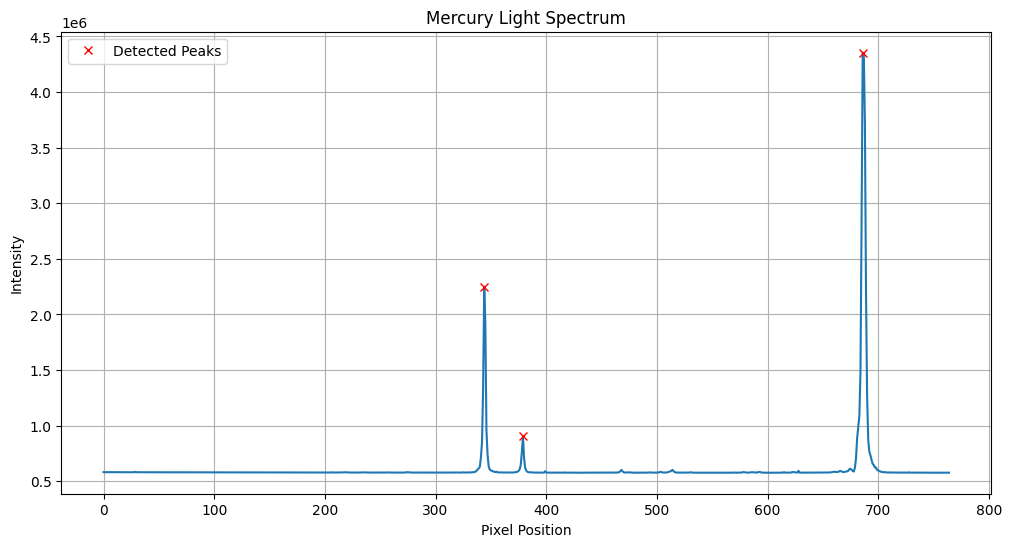

In [11]:
#Finding the peaks of each observed Mercury line

pixel_pos=np.arange(len(average_mercury_spectrum))

peaks, _ = find_peaks(average_mercury_spectrum, prominence=26000)
peak_points= pixel_pos[peaks]

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(pixel_pos, average_mercury_spectrum)
plt.plot(peak_points, average_mercury_spectrum[peaks], "x", label='Detected Peaks', color='red')
plt.title('Mercury Light Spectrum')
plt.xlabel('Pixel Position')
plt.ylabel('Intensity')
plt.legend()
plt.grid()

plt.show()

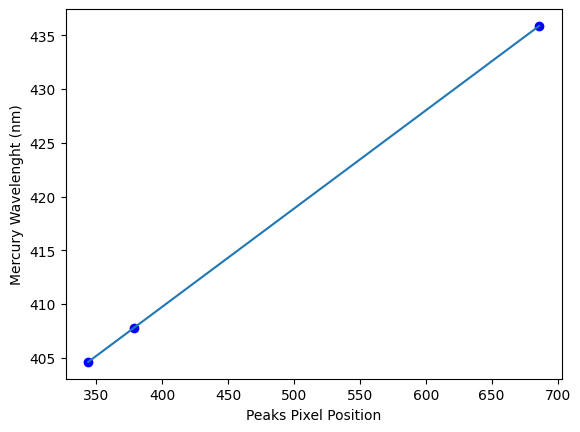

In [12]:
#Finding the pixel to wavelength ratio

w_coef = np.polyfit(peak_points,hg_wavelength,1)
poly1d_w = np.poly1d(w_coef)

plt.plot(peak_points, hg_wavelength, 'bo', peak_points, poly1d_w(peak_points))
plt.xlabel('Peaks Pixel Position')
plt.ylabel('Mercury Wavelenght (nm)')
plt.show()

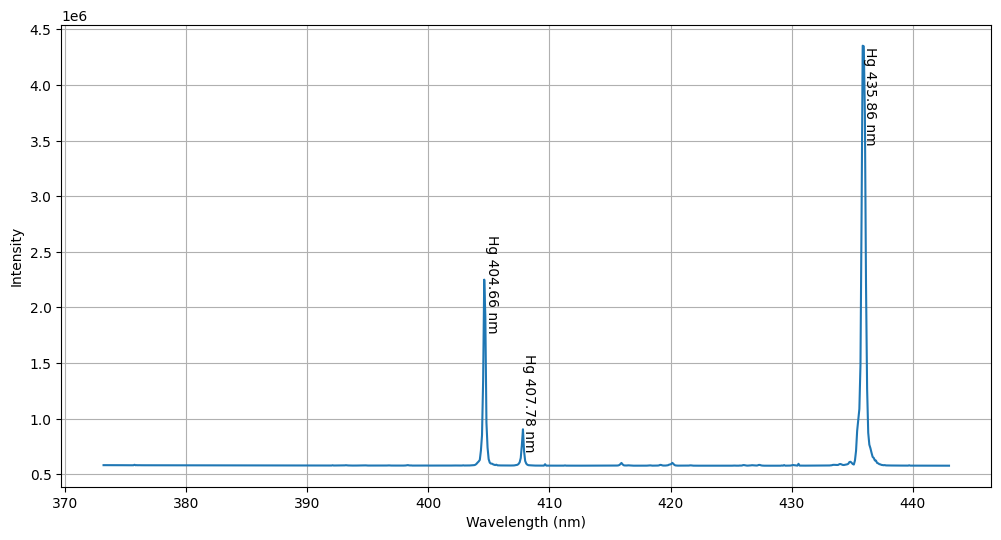

In [13]:
calibrated_wave=(pixel_pos*w_coef[0])+w_coef[1]

plt.figure(figsize=(12, 6))
plt.plot(calibrated_wave, average_mercury_spectrum)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
plt.grid()

# Annotate Neon lines
for i in range(len(hg_wavelength)):
    #plt.axvline(x=n_wavelength[i], ymin=0.1, color='red', linestyle='--')  # Vertical line for each emission line
    plt.text(hg_wavelength[i],average_mercury_spectrum[peaks][i]/1.25, hg_dict[i],
             fontsize=10, rotation=270, color='black', ha='left')

# Flats

In [14]:
#Open the flat field files and grab the data
raw_flats_120=[]

for i in range(5):
    flat_file=f'{ownerpath}/Lab 3/20tau/flats/flats_120s_.0000000{i}.FLAT.FIT'
    flat_file_data=fits.open(flat_file)
    raw_flats_120.append(flat_file_data[0].data)

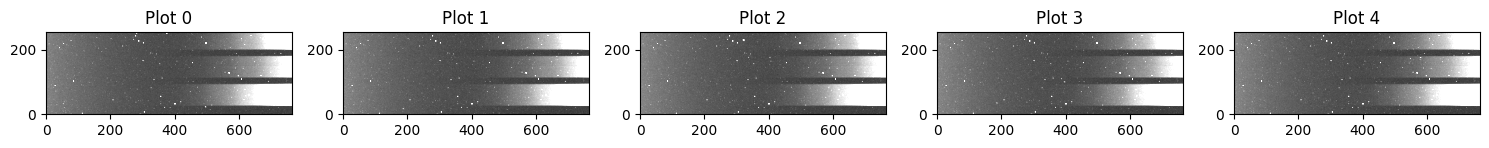

In [15]:
# All 5 Flat Fields
fig, axes = plt.subplots(1, 5, figsize=(15, 25))

# Loop over each subplot and display the images
for i in range(5):
    ax = axes[i]  # Select the appropriate axis
    ax.imshow(raw_flats_120[i],
              vmin=np.mean(raw_flats_120[i]) - np.std(raw_flats_120[i]),
              vmax=np.mean(raw_flats_120[i]) + np.std(raw_flats_120[i]),
              cmap='gray',
              origin='lower')
    ax.set_title(f"Plot {i}")
    #ax.axis('off')  # Optional: Hide axes for a cleaner look

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()

# Master Flat Field

In [16]:
#Average the flat field frames to create the master flat field
master_flat = np.mean(raw_flats_120, axis=0)

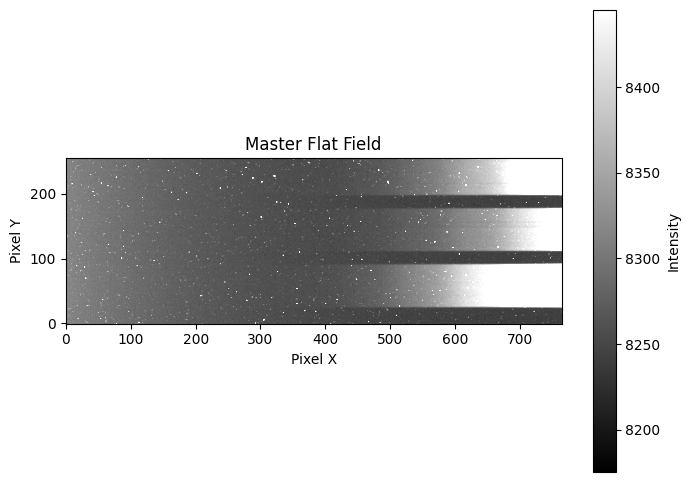

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming raw_flats_120 is a 3D numpy array with shape (n, height, width), where n is the number of flat frames

# Step 1: Average the flat field frames to create the master flat field
master_flat = np.mean(raw_flats_120, axis=0)

# Step 2: Plot the master flat field with similar intensity scaling
plt.figure(figsize=(8, 6))
plt.imshow(master_flat,
           vmin=np.mean(master_flat) - np.std(master_flat),
           vmax=np.mean(master_flat) + np.std(master_flat),
           cmap='gray',
           origin='lower')
plt.colorbar(label='Intensity')
plt.title('Master Flat Field')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')

# Show the plots
plt.show()

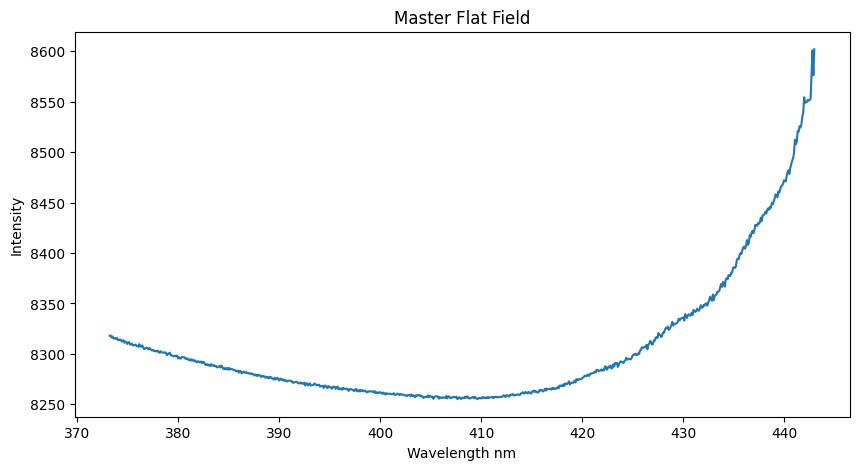

In [18]:
# Step 1:
master_flat_1d= np.median(master_flat, axis=0)

# Step 3: Plot the averaged mercury spectrum
plt.figure(figsize=(10, 5))
plt.plot(calibrated_wave, master_flat_1d)
plt.title("Master Flat Field")
plt.xlabel("Wavelength nm")
plt.ylabel("Intensity")
plt.show()

# Dark

In [19]:
#Open the darks files and grab the data
raw_darks_120=[]

for i in range(5):
    dark_file=f'{ownerpath}/Lab 3/20tau/darks/darks_120s_.0000000{i}.DARK.FIT'
    dark_file_data=fits.open(dark_file)
    raw_darks_120.append(dark_file_data[0].data)

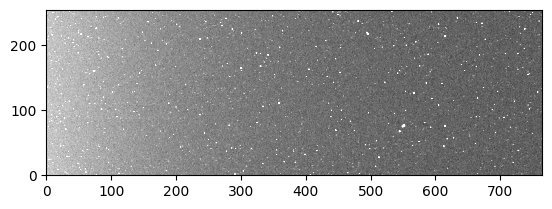

In [20]:
plt.imshow(raw_darks_120[2], vmin=np.mean(raw_darks_120[2])-np.std(raw_darks_120[2]),vmax=np.mean(raw_darks_120[2])+np.std(raw_darks_120[2]), cmap='gray', origin='lower')

# Master Dark Frame

In [21]:
#Average the dark frames to create the master dark
master_dark = np.median(raw_darks_120, axis=0)

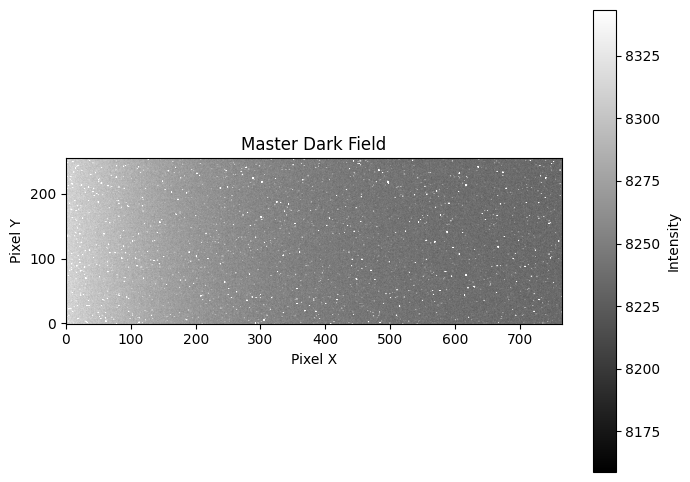

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming raw_darks_120 is a 3D numpy array with shape (n, height, width), where n is the number of dark frames

# Step 1: Average the dark field frames to create the master dark field
master_dark = np.median(raw_darks_120, axis=0)

# Step 2: Plot the master dark field with similar intensity scaling
plt.figure(figsize=(8, 6))
plt.imshow(master_dark,
           vmin=np.median(master_dark) - np.std(master_dark),
           vmax=np.median(master_dark) + np.std(master_dark),
           cmap='gray',
           origin='lower')
plt.colorbar(label='Intensity')
plt.title('Master Dark Field')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')

# Show the plot
plt.show()

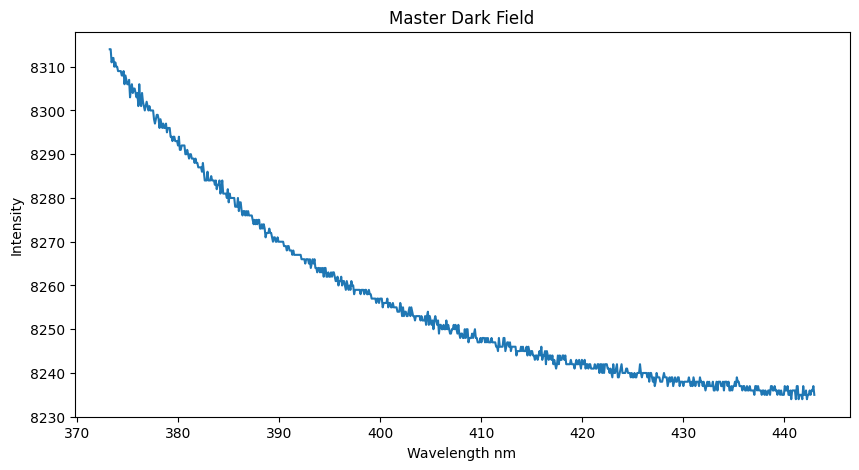

In [23]:
# Step 1: Sum along the y-axis for each mercury frame
master_dark_1d= np.median(master_dark, axis=0)

# Step 3: Plot the averaged mercury spectrum
plt.figure(figsize=(10, 5))
plt.plot(calibrated_wave, master_dark_1d)
plt.title("Master Dark Field")
plt.xlabel("Wavelength nm")
plt.ylabel("Intensity")
plt.show()

# Making dark cuts for each star

In [24]:
# List to hold the cut data of each dark frame for 20tau
darks_20tau_cut = []

# Define the y-axis ranges for each frame
dark20_y_ranges = [(27, 63), (44, 80), (46, 82), (62, 98), (56, 92),
            (60, 96), (59, 95), (60, 96), (61, 97), (61, 97)]

# Loop through each corrected frame, open it, cut along y-axis, and extract the data
for i in range(10):
    # Cut the frame data along the y-axis according to the specified range
    y_start, y_end = dark20_y_ranges[i]
    cut_frame_data = master_dark[y_start:y_end, :]

    # Append the cut frame data to the list
    darks_20tau_cut.append(cut_frame_data)

In [25]:
# List to hold the cut data of each dark frame for etatau
darks_etatau_cut = []

# Define the y-axis ranges for each frame
y_ranges_eta = [(51, 71), (51, 71), (54, 74), (55, 75), (57, 77),
                (58, 78), (60, 80), (61, 81), (61, 81), (61, 81)]

# Loop through each corrected frame, open it, cut along y-axis, and extract the data
for i in range(10):
    # Cut the frame data along the y-axis according to the specified range
    y_start, y_end = y_ranges_eta[i]
    cut_frame_data = master_dark[y_start:y_end, :]

    # Append the cut frame data to the list
    darks_etatau_cut.append(cut_frame_data)

In [26]:
# List to hold the cut data of each dark frame for qtau
darks_qtau_cut = []

# Define the y-axis ranges for each frame
y_ranges_qtau = [(46, 76), (45, 75), (56, 86), (57, 87), (54, 84),
                 (52, 82), (54, 84), (53, 83), (48, 78), (52, 82)]

# Loop through each corrected frame, open it, cut along y-axis, and extract the data
for i in range(10):
    # Cut the frame data along the y-axis according to the specified range
    y_start, y_end = y_ranges_qtau[i]
    cut_frame_data = master_dark[y_start:y_end, :]

    # Append the cut frame data to the list
    darks_qtau_cut.append(cut_frame_data)

# Cutting Master Flat and Dark

In [27]:
#Define pixel cut for flat field and Dark frame
y_ranges_flat = [(24, 94)]

# Cut the frame data along the y-axis according to the specified range
flat_y_start, flat_y_end = y_ranges_flat[0]
master_flat_cut = master_flat[flat_y_start:flat_y_end, :]
master_dark_cut = master_dark[flat_y_start:flat_y_end, :]

master_flat_dark = master_flat_cut - master_dark_cut

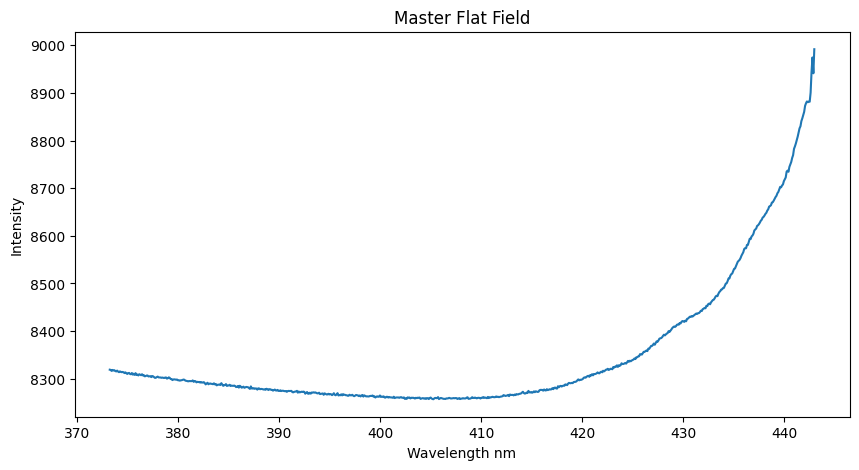

In [28]:
# Step 1: Sum along the y-axis for each mercury frame
master_flatcut_1d= np.median(master_flat_cut, axis=0)

# Step 3: Plot the averaged mercury spectrum
plt.figure(figsize=(10, 5))
plt.plot(calibrated_wave, master_flatcut_1d)
plt.title("Master Flat Field")
plt.xlabel("Wavelength nm")
plt.ylabel("Intensity")
# plt.xlim(375, 410)
# plt.ylim(8230, 8320)
plt.show()

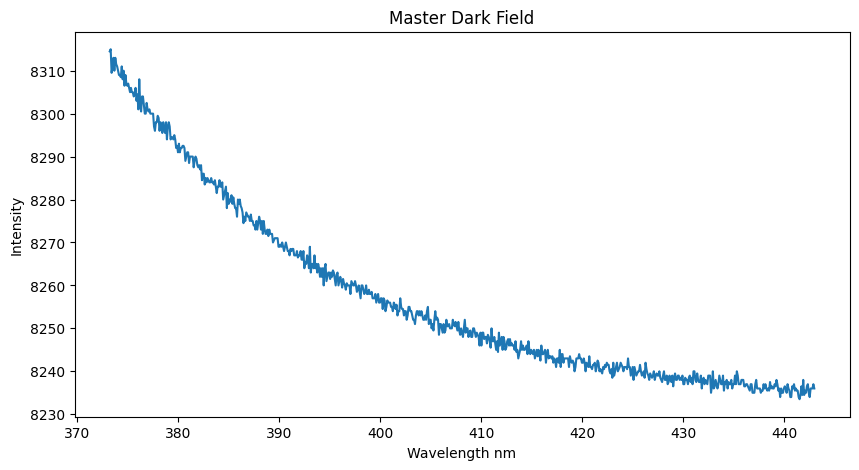

In [29]:
# Step 1: Sum along the y-axis for each mercury frame
master_darkcut_1d= np.median(master_dark_cut, axis=0)

# Step 3: Plot the averaged mercury spectrum
plt.figure(figsize=(10, 5))
plt.plot(calibrated_wave, master_darkcut_1d)
plt.title("Master Dark Field")
plt.xlabel("Wavelength nm")
plt.ylabel("Intensity")
plt.show()

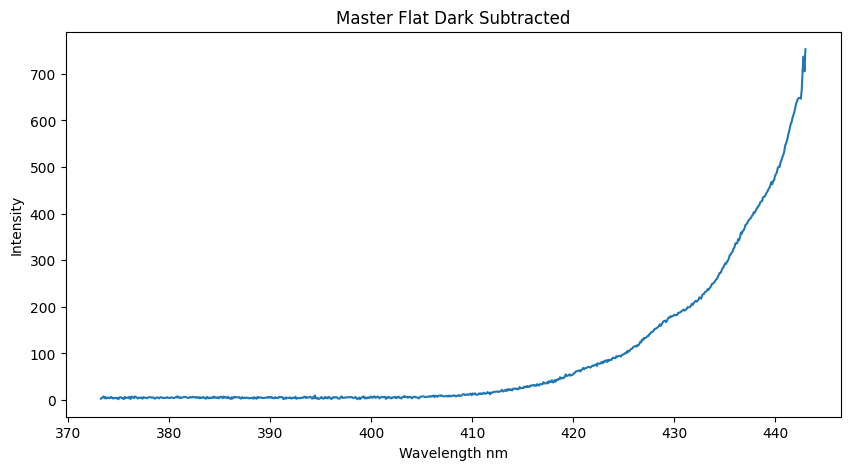

8.172673235286604


In [30]:
# Step 1: Sum along the y-axis for each mercury frame
master_flatdark_1d= np.median(master_flat_dark, axis=0)

# Step 3: Plot the averaged mercury spectrum
plt.figure(figsize=(10, 5))
plt.plot(calibrated_wave, master_flatdark_1d)
plt.title("Master Flat Dark Subtracted")
plt.xlabel("Wavelength nm")
plt.ylabel("Intensity")
#plt.xlim(0, 500)
plt.show()
print(np.max(master_flatdark_1d/np.mean(master_flatdark_1d)))

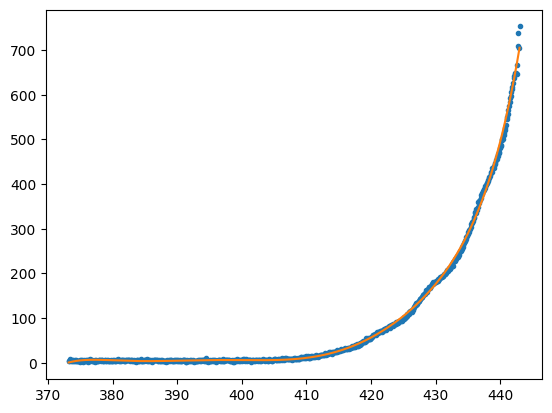

In [31]:
z = np.polyfit(calibrated_wave, master_flatdark_1d, 9)

p = np.poly1d(z)

plt.plot(calibrated_wave, master_flatdark_1d, '.', calibrated_wave, p(calibrated_wave), '-')
# plt.xlim(360, 410)
# plt.ylim(0, 10.5)

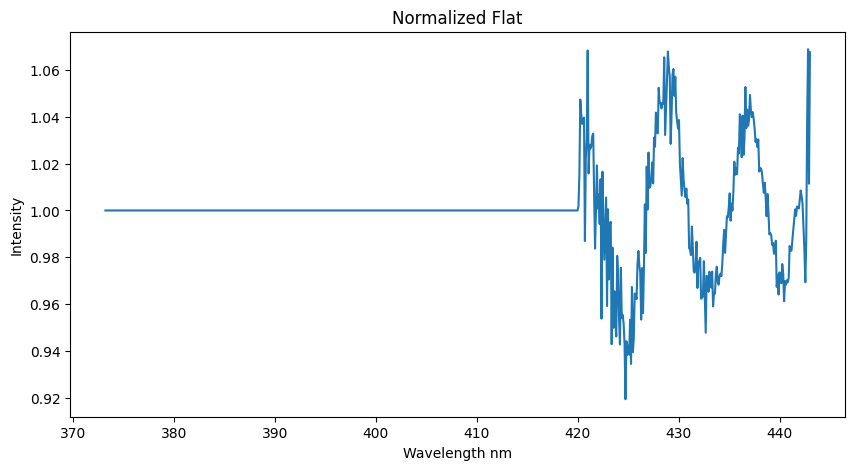

In [32]:
normalized_flat = master_flatdark_1d / p(calibrated_wave)

normalized_flat[calibrated_wave<420] = 1

plt.figure(figsize=(10, 5))
plt.plot(calibrated_wave, normalized_flat)
plt.title("Normalized Flat")
plt.xlabel("Wavelength nm")
plt.ylabel("Intensity")
# plt.xlim(420, 445)
# plt.ylim(0.75, 1.25)
plt.show()

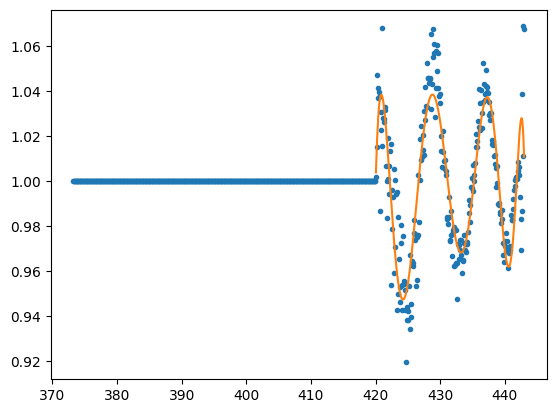

In [33]:
z2 = np.polyfit(calibrated_wave[513:], normalized_flat[513:], 90)

p2 = np.poly1d(z2)

plt.plot(calibrated_wave, normalized_flat, '.', calibrated_wave[513:],
         p2(calibrated_wave[513:]), '-')
# plt.xlim(400,450)
# plt.ylim(0.5, 1.75)

In [34]:
normalized_flat[513:]= normalized_flat[513:] / p2(calibrated_wave[513:])

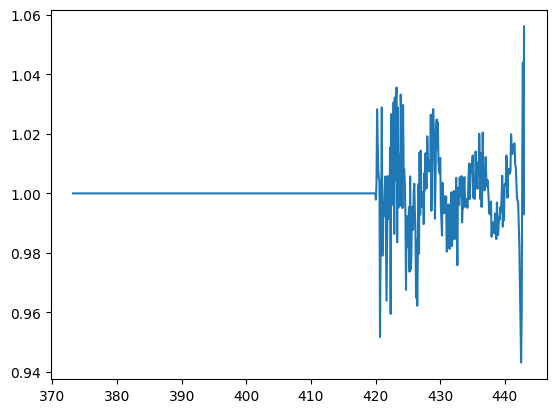

In [35]:
plt.plot(calibrated_wave, normalized_flat)
#plt.plot(normalized_flat[:513])

# 20Tau

In [36]:
identified_maia_lines = {
    # "H12 375.01 nm": 375.01,
    # "H11 377.06 nm": 377.06,
    # "H10 379.79 nm": 379.79,
    # "He I 381.96 nm": 381.96,
    # "H9 383.54 nm" : 383.54,
    # "Si II 385.6 nm": 385.60,
    # "Si II 386.26 nm": 386.26,
    # "H8 388.90 nm": 388.90,
    # "Ti II 390.05 nm": 390.05,
     "Ca II 393.36 nm": 393.36,
    # "H epsilon 397.0 nm": 397.0,
    # "He I 402.61 nm": 402.61,
    # "H delta 410.17 nm": 410.17,
    # "He I 412.08 nm": 412.08,
     "Si II 413.08 nm": 413.08,
    # "Fe II 417.88 nm": 417.88,
    # "Fe II 423.32 nm": 423.32,
    # "C II 426.70 nm": 426.7,
    # "H gamma 434.0 nm": 434.0,
    # "Fe II 435.17 nm": 435.17,
     "Mg II 438.4 nm": 438.3
}

maia_wavelength=sorted(identified_maia_lines.values())
maia_dict=list(identified_maia_lines.keys())

In [37]:
(maia_dict)

['Ca II 393.36 nm', 'Si II 413.08 nm', 'Mg II 438.4 nm']

In [38]:
#Open the 20tau light frame files and extract the data
raw_20tau=[]

for i in range(10):
    if i < 10:
        tau20_file = f'{ownerpath}/Lab 3/20tau/pleiades_light/20tau_light_120s_.0000000{i}.FIT'
    elif i < 20 :
        tau20_file = f'{ownerpath}/Lab 3/20tau/pleiades_light/20tau_light_120s_.000000{i}.FIT'
    tau20_file_data=fits.open(tau20_file)
    raw_20tau.append(tau20_file_data[0].data)

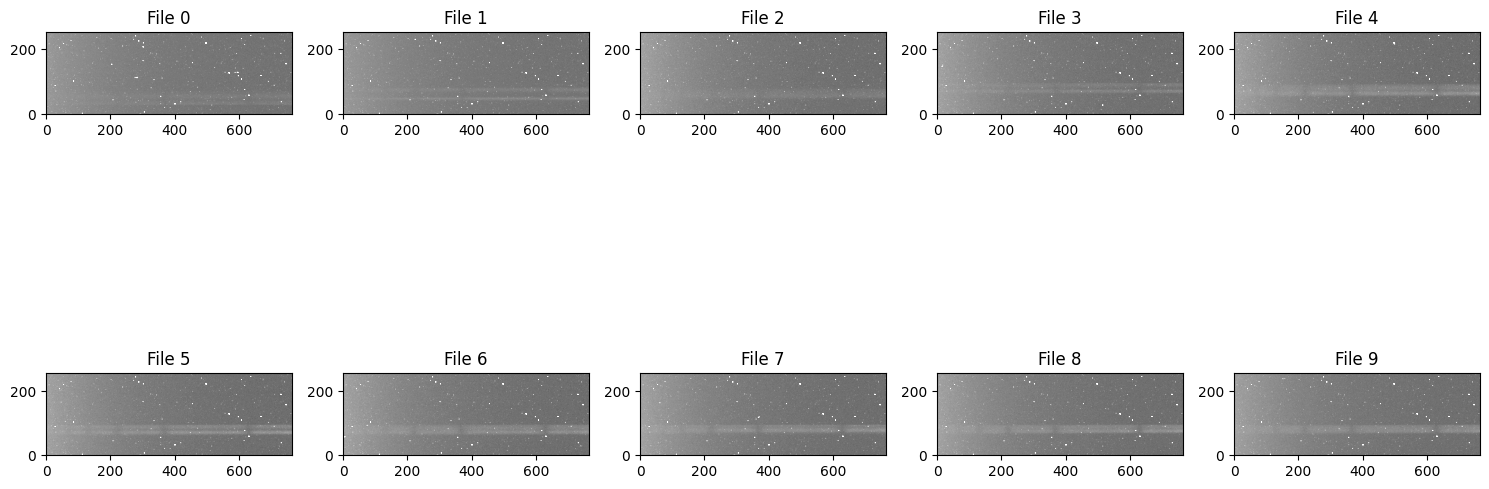

In [39]:
# All light frames of 20 Tau
fig, axes = plt.subplots(2, 5, figsize=(15, 9))  # 2 rows, 5 columns

# Loop through each image and display it on a subplot
for i, ax in enumerate(axes.flat):
    if i < len(raw_20tau):  # Ensure we're not going out of bounds
        ax.imshow(
            raw_20tau[i],
            vmin=np.mean(raw_20tau[i]) - (2 * np.std(raw_20tau[i])),
            vmax=np.mean(raw_20tau[i]) + (2 * np.std(raw_20tau[i])),
            cmap='gray',
            origin='lower'
        )
        ax.set_title(f"File {i}")  # Title for each subplot
        #ax.axis('off')  # Optionally hide the axis for cleaner look

plt.tight_layout()  # Adjust spacing for a nicer layout
plt.show()

In [40]:
# List to hold the cut data of each corrected 20 Tau frame
raw_20tau_cut = []

# Define the y-axis ranges for each frame
y_20tau_ranges = [(27, 63), (44, 80), (46, 82), (62, 98), (56, 92),
            (60, 96), (59, 95), (60, 96), (61, 97), (61, 97)]

# Loop through each corrected frame, open it, cut along y-axis, and extract the data
for i in range(10):
#     tau20_corrected_file = f'{ownerpath}/Lab 3/20tau/corrected_pleiades_light/final_20tau_frame_00{i}.FIT'
#     tau20_corrected_file_data = fits.open(tau20_corrected_file)

#     # Get the full frame data
#     frame_data = tau20_corrected_file_data[0].data

    # Cut the frame data along the y-axis according to the specified range
    y_start, y_end = y_20tau_ranges[i]
    cut_frame_data = raw_20tau[i][y_start:y_end, :]

    # Append the cut frame data to the list
    raw_20tau_cut.append(cut_frame_data)

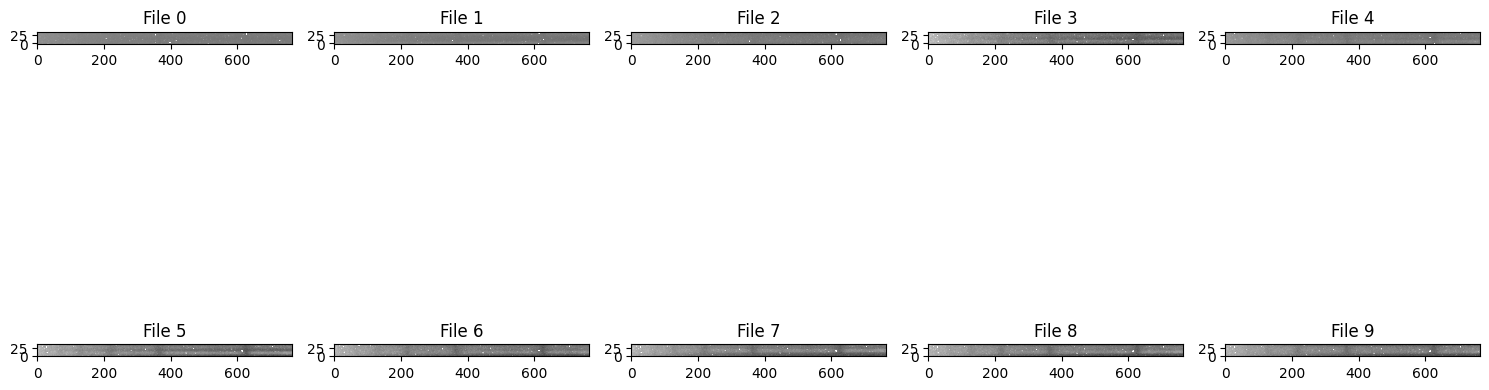

In [41]:
# All light frames of 20 Tau
fig, axes = plt.subplots(2, 5, figsize=(15, 9))  # 2 rows, 5 columns

# Loop through each image and display it on a subplot
for i, ax in enumerate(axes.flat):
    if i < len(raw_20tau_cut):  # Ensure we're not going out of bounds
        ax.imshow(
            raw_20tau_cut[i],
            vmin=np.mean(raw_20tau_cut[i]) - (2 * np.std(raw_20tau_cut[i])),
            vmax=np.mean(raw_20tau_cut[i]) + (2 * np.std(raw_20tau_cut[i])),
            cmap='gray',
            origin='lower'
        )
        ax.set_title(f"File {i}")  # Title for each subplot
        #ax.axis('off')  # Optionally hide the axis for cleaner look

plt.tight_layout()  # Adjust spacing for a nicer layout
plt.show()

In [42]:
darksubtracted_20tau = []
for i in range(10):
    dark_sub=raw_20tau_cut[i]-darks_20tau_cut[i]
    darksubtracted_20tau.append(dark_sub)

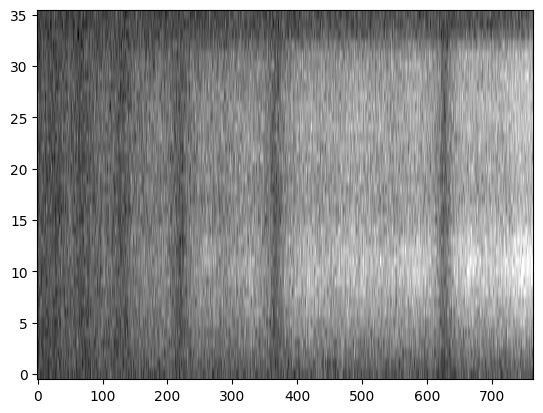

In [43]:
master_20tau = (np.median(darksubtracted_20tau, axis=0))

plt.imshow(master_20tau, cmap='gray',
           vmin=np.mean(master_20tau) - (3 * np.std(master_20tau)),
           vmax=np.mean(master_20tau) + (3 * np.std(master_20tau)), aspect='auto', origin='lower')

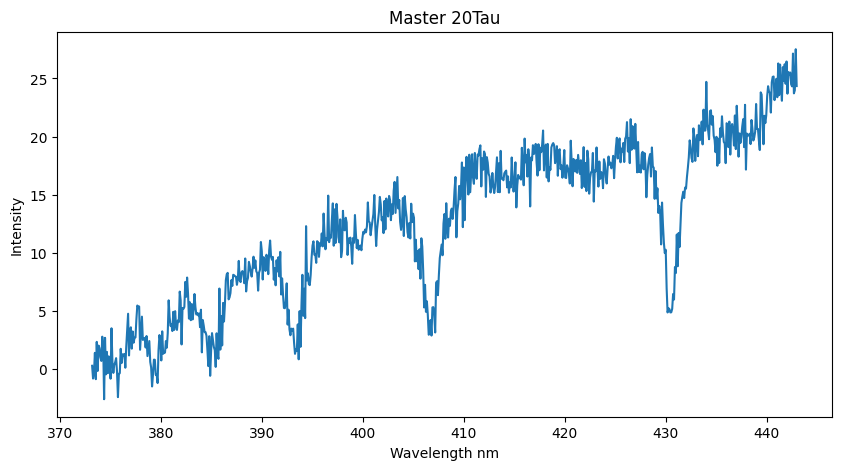

27.51388888888889


In [44]:
# Step 1: Sum along the y-axis for each mercury frame
master_20tau_1d= np.mean(master_20tau, axis=0)

# Step 3: Plot the averaged mercury spectrum
plt.figure(figsize=(10, 5))
plt.plot(calibrated_wave, master_20tau_1d)
plt.title("Master 20Tau")
plt.xlabel("Wavelength nm")
plt.ylabel("Intensity")
plt.show()
print(np.max(master_20tau_1d))

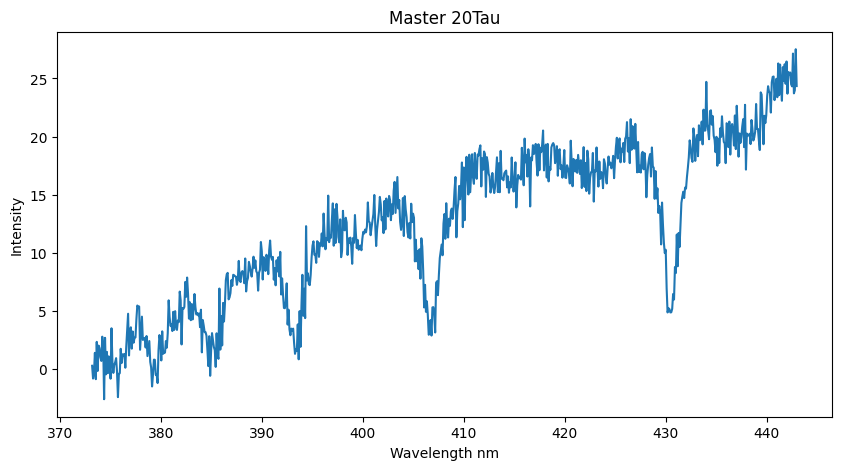

In [45]:
norm_master_20tau = master_20tau_1d/normalized_flat

plt.figure(figsize=(10, 5))
#plt.plot(calibrated_wave, norm_master_20tau)
plt.plot(calibrated_wave, master_20tau_1d)
plt.title("Master 20Tau")
plt.xlabel("Wavelength nm")
plt.ylabel("Intensity")
# plt.xlim(420, 445)
# plt.ylim(-100, 500)
plt.show()


In [46]:

peaks_right, _ = find_peaks(master_20tau_1d[410:], threshold=0.1, prominence=3)
peak_right= calibrated_wave[410:][peaks_right]


peaks_mid, _ = find_peaks(master_20tau_1d[210:410], threshold=0.2, distance=4, prominence=1.9, height=6)
peak_mid= calibrated_wave[210:410][peaks_mid]


peaks_left, _ = find_peaks(master_20tau_1d[:210], threshold=0.1, distance=10, height=2.52)
peak_left= calibrated_wave[:210][peaks_left]



In [47]:
# peaks_20tau=[*master_20tau_1d[:210][peaks_left], *master_20tau_1d[210:410][peaks_mid], *master_20tau_1d[413:][peaks_right]]


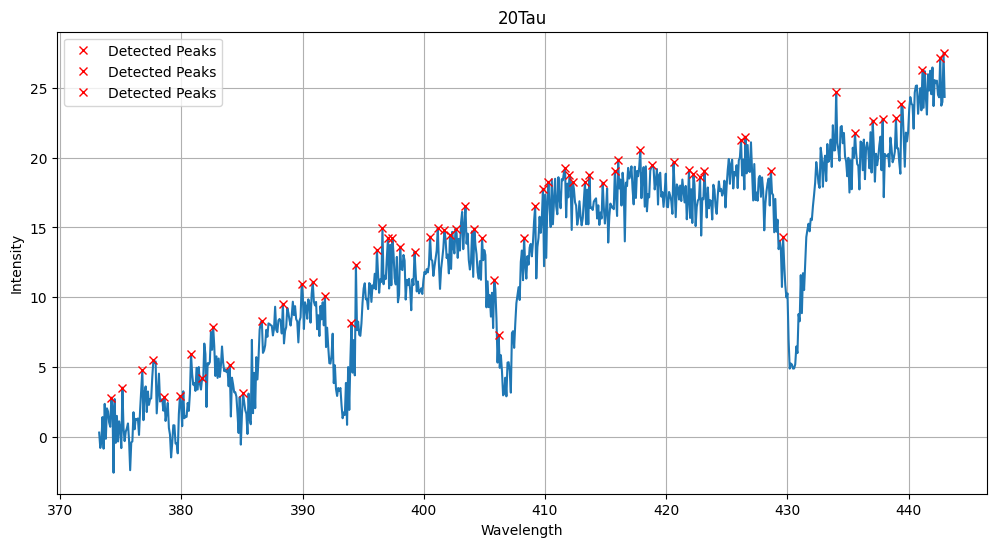

[ 2.80555556  3.52777778  4.77777778  5.48611111  2.86111111  2.94444444
  5.93055556  4.20833333  7.88888889  5.125       3.11111111  8.29166667
  9.52777778 10.94444444 11.06944444 10.09722222]


In [48]:
plt.figure(figsize=(12, 6))
plt.plot(calibrated_wave, master_20tau_1d)
plt.plot(calibrated_wave[410:][peaks_right], master_20tau_1d[410:][peaks_right], "x", label='Detected Peaks', color='red')
plt.plot(calibrated_wave[210:410][peaks_mid], master_20tau_1d[210:410][peaks_mid], "x", label='Detected Peaks', color='red')
plt.plot(calibrated_wave[:210][peaks_left], master_20tau_1d[:210][peaks_left], "x", label='Detected Peaks', color='red')
plt.title('20Tau')
plt.xlabel('Wavelength')
plt.ylabel('Intensity')
plt.legend()
plt.grid()

plt.show()
print(master_20tau_1d[:210][peaks_left])

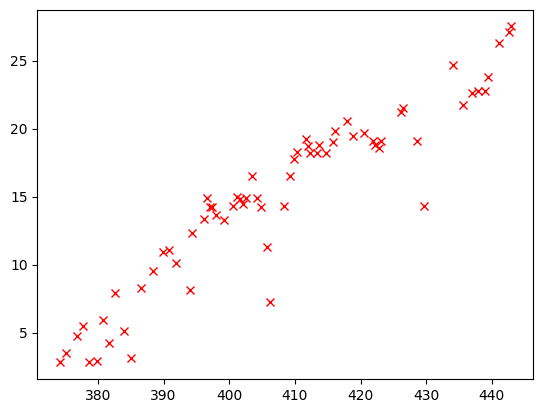

In [49]:
plt.plot(calibrated_wave[410:][peaks_right], master_20tau_1d[410:][peaks_right], "x", label='Detected Peaks', color='red')
plt.plot(calibrated_wave[210:410][peaks_mid], master_20tau_1d[210:410][peaks_mid], "x", label='Detected Peaks', color='red')
plt.plot(calibrated_wave[:210][peaks_left], master_20tau_1d[:210][peaks_left], "x", label='Detected Peaks', color='red')

In [50]:
ivytmp = np.column_stack((
    np.row_stack((calibrated_wave[:210][peaks_left], master_20tau_1d[:210][peaks_left])),
    np.row_stack((calibrated_wave[210:410][peaks_mid], master_20tau_1d[210:410][peaks_mid])),
    np.row_stack((calibrated_wave[410:][peaks_right], master_20tau_1d[410:][peaks_right]))
))
ivytmp

array([[374.21386513, 375.12708028, 376.77086755, 377.6840827 ,
        378.59729785, 379.87579906, 380.78901421, 381.70222936,
        382.61544451, 383.98526723, 385.08112541, 386.63359117,
        388.36869995, 389.9211657 , 390.83438085, 391.83891752,
        394.03063388, 394.39591994, 396.13102872, 396.5876363 ,
        397.04424387, 397.40952993, 398.04878054, 399.23596023,
        400.51446144, 401.15371205, 401.70164114, 402.15824871,
        402.61485629, 403.43674992, 404.16732204, 404.80657265,
        405.81110931, 406.17639537, 408.27679022, 409.19000537,
        409.82925597, 410.28586355, 411.65568627, 412.02097233,
        412.29493688, 413.29947354, 413.6647596 , 414.76061778,
        415.76515445, 416.03911899, 417.86554929, 418.87008595,
        420.60519474, 421.88369595, 422.24898201, 422.7969111 ,
        423.16219716, 426.17580715, 426.54109321, 428.64148806,
        429.64602472, 434.02945744, 435.5819232 , 437.04306744,
        437.86496107, 438.96081925, 439.

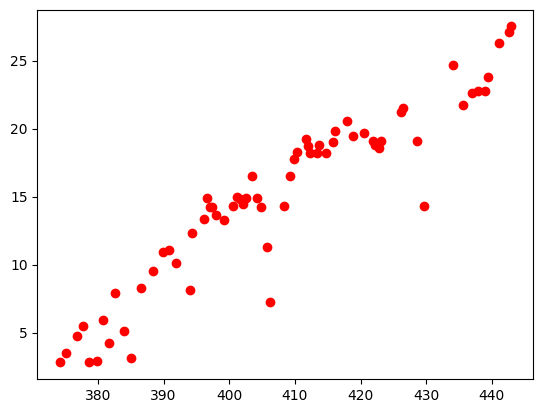

In [51]:
plt.scatter(ivytmp[0], ivytmp[1], color='red')

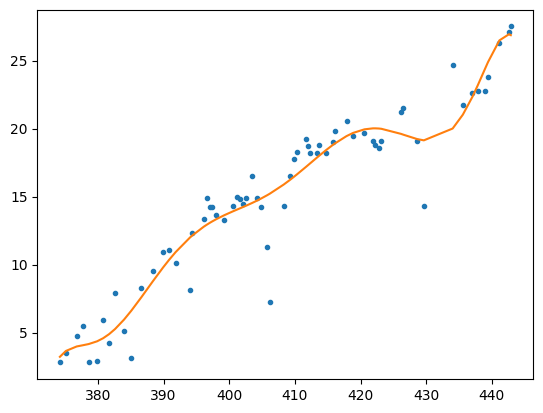

In [52]:
peak_20tau_coeff = np.polyfit(ivytmp[0], ivytmp[1], 9)

poly_20tau = np.poly1d(peak_20tau_coeff)

plt.plot(ivytmp[0], ivytmp[1], '.', ivytmp[0], poly_20tau(ivytmp[0]), '-')
# plt.xlim(360, 410)
# plt.ylim(0, 10.5)

In [53]:
# Constants
h = 6.62607015e-34  # Planck's constant (J·s)
c = 3.0e8           # Speed of light (m/s)
k_B = 1.380649e-23  # Boltzmann constant (J/K)

# Define Planck's law for blackbody radiation
def blackbody_spectrum(wavelength, T):
    """Planck's law for blackbody radiation in terms of wavelength."""
    wavelength_m = wavelength * 1e-9  # Convert from nm to m
    B_lambda = (2 * h * c**2) / (wavelength_m**5) * (1 / (np.exp((h * c) / (wavelength_m * k_B * T)) - 1))
    return B_lambda

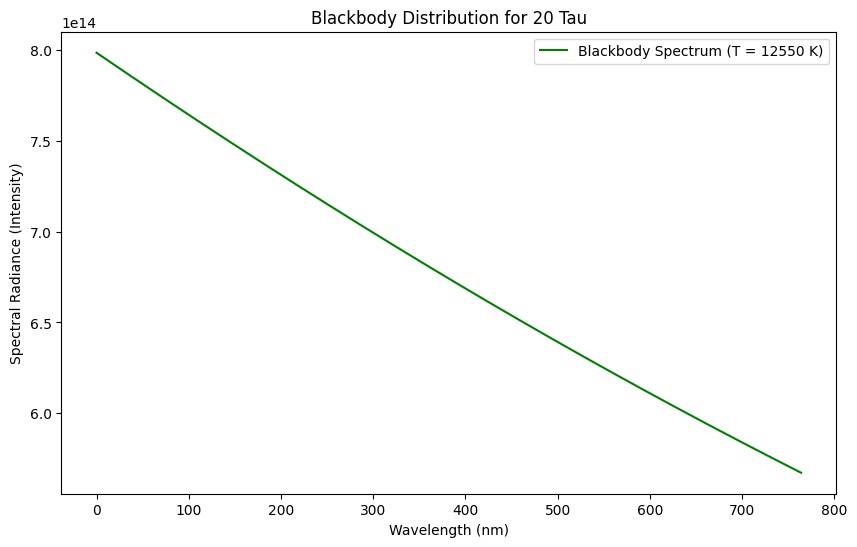

In [54]:
# Given temperature of 20 Tau
Temp_20_tau = 12550  # K

# Step 1: Generate the blackbody spectrum for 20 Tau
bb_spectrum_20tau = blackbody_spectrum(calibrated_wave, Temp_20_tau)

# Step 2: Plot the blackbody spectrum
plt.figure(figsize=(10, 6))
plt.plot(bb_spectrum_20tau, label=f'Blackbody Spectrum (T = {Temp_20_tau} K)', color='green')
plt.title("Blackbody Distribution for 20 Tau")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Spectral Radiance (Intensity)")
plt.legend()
plt.show()

In [55]:
len(poly_20tau(calibrated_wave))

765

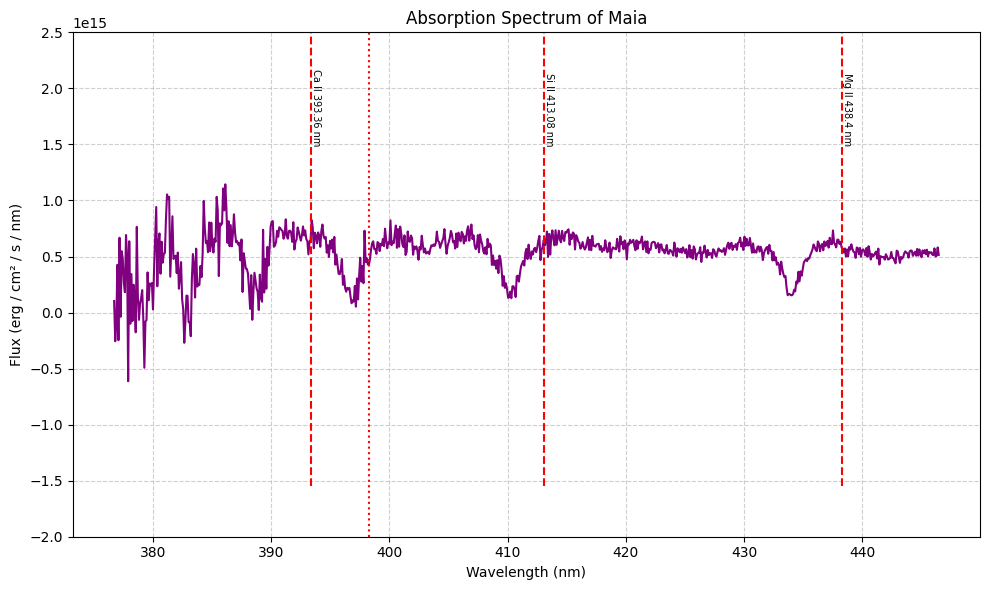

In [56]:
# Calculate the Result: (Original Spectrum * Blackbody Spectrum) / Continuum Spectrum
result_20tau = (master_20tau_1d * bb_spectrum_20tau) / poly_20tau(calibrated_wave)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(calibrated_wave+3.5, result_20tau, label="Absorption Spectrum", color='purple')
plt.title("Absorption Spectrum of Maia")
plt.xlabel("Wavelength (nm)")
# plt.xlim(390, 405)
plt.ylabel("Flux (erg / cm² / s / nm)")
plt.ylim(-2e15, 2.5e15)
plt.grid(True, linestyle='--', alpha=0.6)

# Add a vertical dotted line at 398.3 nm
plt.axvline(x=398.3, color='r', linestyle=':', label='398.3 nm')

for i in range(len(maia_wavelength)):
    plt.axvline(x=maia_wavelength[i], ymin=0.1, color='red', linestyle='--')  # Vertical line for each emission line
    plt.text(maia_wavelength[i],1.5e15, f' {maia_dict[i]}',
             fontsize=7, rotation=270, color='black', ha='left')
#plt.legend()
plt.tight_layout()
plt.show()

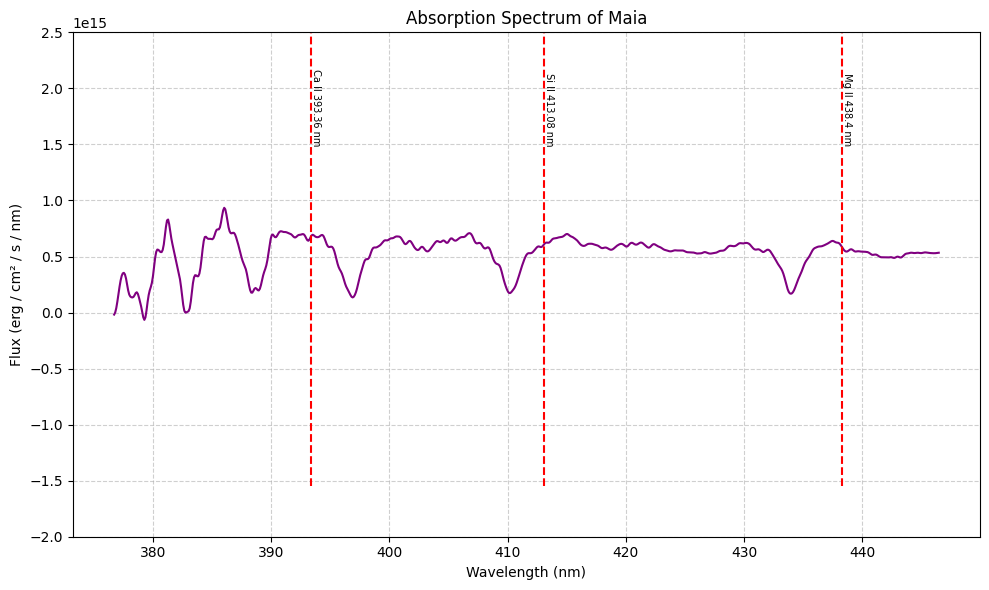

In [57]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Apply Gaussian smoothing to the 20 Tau result
smoothed_result_20tau = gaussian_filter1d(result_20tau, sigma=2)  # Adjust sigma for more/less smoothing

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(calibrated_wave + 3.5, smoothed_result_20tau, label="Smoothed Absorption Spectrum", color='purple')
plt.title("Absorption Spectrum of Maia")
plt.xlabel("Wavelength (nm)")
# plt.xlim(390, 405)  # Uncomment if you want to limit the x-axis range
plt.ylabel("Flux (erg / cm² / s / nm)")
plt.ylim(-2e15, 2.5e15)
plt.grid(True, linestyle='--', alpha=0.6)

# Add vertical lines and labels for each emission line
for i in range(len(maia_wavelength)):
    plt.axvline(x=maia_wavelength[i], ymin=0.1, color='red', linestyle='--')  # Vertical line for each emission line
    plt.text(maia_wavelength[i], 1.5e15, f' {maia_dict[i]}',
             fontsize=7, rotation=270, color='black', ha='left')

# Show the plot
plt.tight_layout()
plt.show()

# Eta Tau

In [58]:
#Open the etatau light frame files and extract the data
raw_etatau=[]

for i in range(10):
    taueta_file = f'{ownerpath}/Lab 3/20tau/pleiades_light/etatau_light_120s_.0000000{i}.FIT'
    taueta_file_data=fits.open(taueta_file)
    raw_etatau.append(taueta_file_data[0].data)

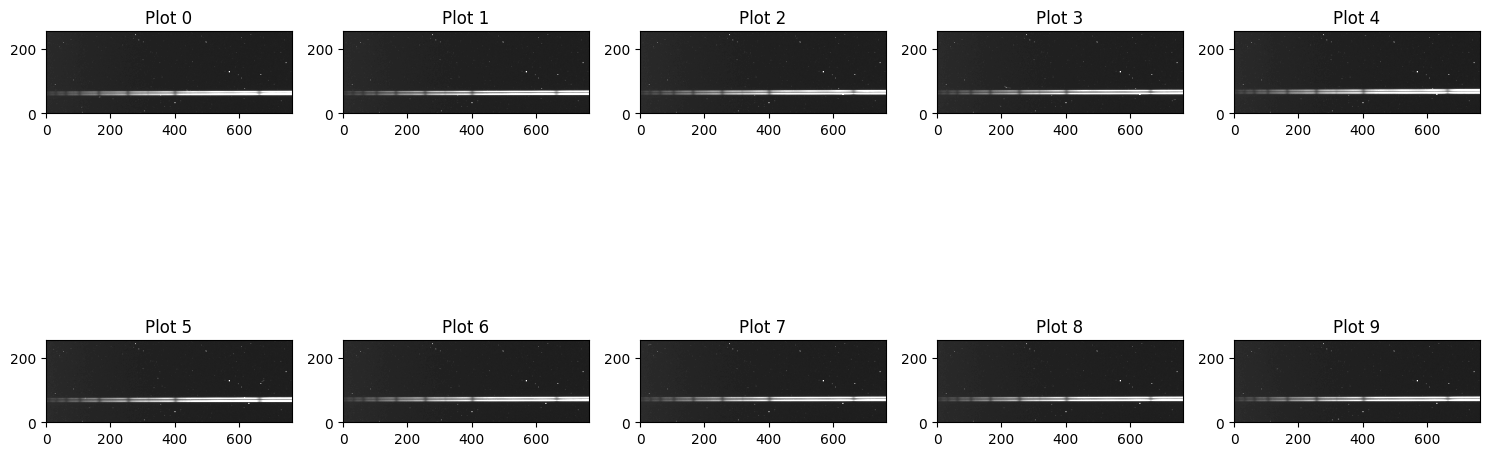

In [59]:
# All 10 light frames of eta Tau
fig, axes = plt.subplots(2, 5, figsize=(15, 8))  # 2 rows, 5 columns grid for 10 plots
axes = axes.ravel()  # Flatten the 2D array of axes to make indexing easier

for i in range(10):  # Loop through the 10 indices (0 to 9)
    axes[i].imshow(raw_etatau[i],
                   vmin=np.mean(raw_etatau[i]) - np.std(raw_etatau[i]),
                   vmax=np.mean(raw_etatau[i]) + (5 * np.std(raw_etatau[i])),
                   cmap='gray', origin='lower')
    axes[i].set_title(f"Plot {i}")  # Optionally, label each subplot
    #axes[i].axis('off')  # Turn off axis for better visualization

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [60]:
# List to hold the cut data of each corrected Eta Tau frame
etatau_cut = []

# Define the y-axis ranges for each frame
y_ranges_eta = [(51, 71), (51, 71), (54, 74), (55, 75), (57, 77),
                (58, 78), (60, 80), (61, 81), (61, 81), (61, 81)]

# Loop through each corrected frame, cut along y-axis, and extract the data
for i in range(10):
    # Get the full frame data
    frame_data = raw_etatau[i]

    # Cut the frame data along the y-axis according to the specified range
    y_start, y_end = y_ranges_eta[i]
    cut_frame_data = frame_data[y_start:y_end, :]

    # Append the cut frame data to the list
    etatau_cut.append(cut_frame_data)

In [61]:
darksubtracted_etatau = []
for i in range(10):
    dark_sub=etatau_cut[i]-darks_etatau_cut[i]
    darksubtracted_etatau.append(dark_sub)

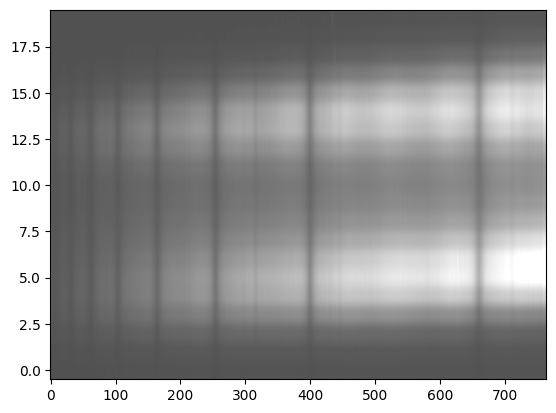

In [62]:
master_etatau = (np.mean(darksubtracted_etatau, axis=0))
master_etatau_1d= np.mean(master_etatau, axis=0)

plt.imshow(master_etatau, cmap='gray',
           vmin=np.mean(master_etatau) - (3 * np.std(master_etatau)),
           vmax=np.mean(master_etatau) + (3 * np.std(master_etatau)), aspect='auto', origin='lower')

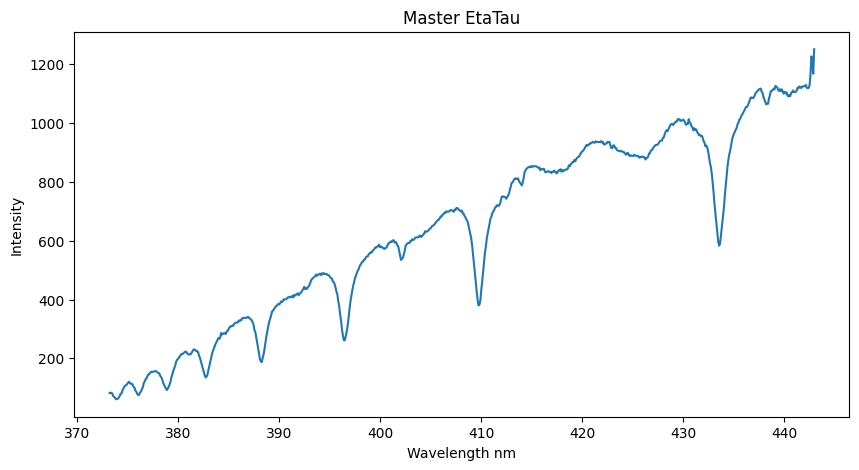

In [63]:
norm_master_etatau = master_etatau_1d/normalized_flat

plt.figure(figsize=(10, 5))
plt.plot(calibrated_wave, master_etatau_1d)
#plt.plot(calibrated_wave, norm_master_etatau)
plt.title("Master EtaTau")
plt.xlabel("Wavelength nm")
plt.ylabel("Intensity")
# plt.xlim(420, 445)
# plt.ylim(-100, 500)
# for i in range(len(maia_wavelength)):
#     plt.axvline(x=maia_wavelength[i], ymin=0.1, color='red', linestyle='--')  # Vertical line for each emission line
#     plt.text(maia_wavelength[i],100, f' {maia_dict[i]}',
#              fontsize=7, rotation=270, color='black', ha='left')
plt.show()

In [64]:
eta_peaks_right, _ = find_peaks(master_etatau_1d[410:], prominence=4.3)
eta_peak_right= calibrated_wave[410:][eta_peaks_right]


eta_peaks_mid, _ = find_peaks(master_etatau_1d[210:410], prominence=2.6)
eta_peak_mid= calibrated_wave[210:410][eta_peaks_mid]


eta_peaks_left, _ = find_peaks(master_etatau_1d[:210], prominence=1.2)
eta_peak_left= calibrated_wave[:210][eta_peaks_left]


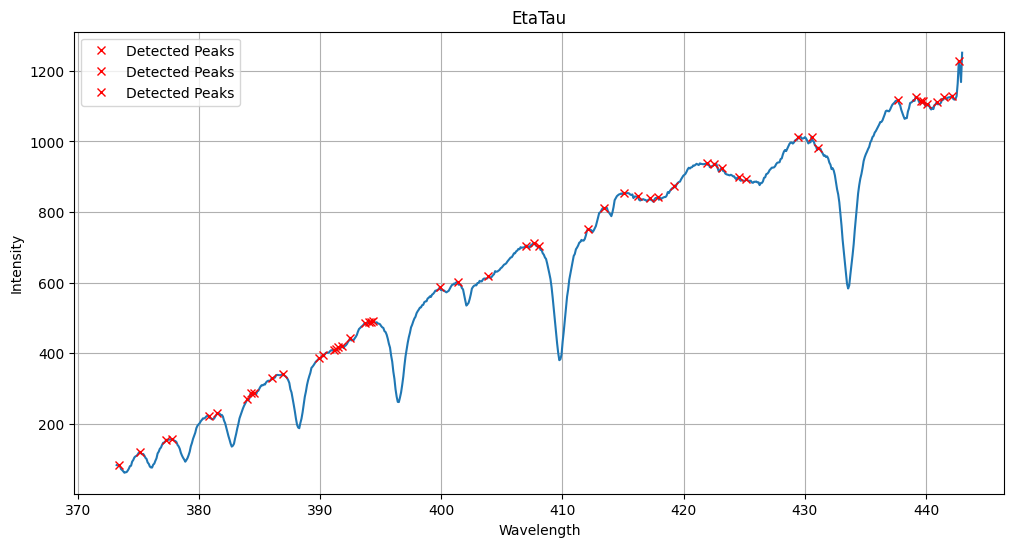

In [65]:
plt.figure(figsize=(12, 6))
plt.plot(calibrated_wave, master_etatau_1d)
plt.plot(calibrated_wave[410:][eta_peaks_right], master_etatau_1d[410:][eta_peaks_right], "x", label='Detected Peaks', color='red')
plt.plot(calibrated_wave[210:410][eta_peaks_mid], master_etatau_1d[210:410][eta_peaks_mid], "x", label='Detected Peaks', color='red')
plt.plot(calibrated_wave[:210][eta_peaks_left], master_etatau_1d[:210][eta_peaks_left], "x", label='Detected Peaks', color='red')
plt.title('EtaTau')
plt.xlabel('Wavelength')
plt.ylabel('Intensity')
plt.legend()
plt.grid()

plt.show()

In [66]:
ivytmp_eta = np.column_stack((
    np.row_stack((calibrated_wave[:210][eta_peaks_left], master_etatau_1d[:210][eta_peaks_left])),
    np.row_stack((calibrated_wave[210:410][eta_peaks_mid], master_etatau_1d[210:410][eta_peaks_mid])),
    np.row_stack((calibrated_wave[410:][eta_peaks_right], master_etatau_1d[410:][eta_peaks_right]))
))
ivytmp_eta

array([[ 373.39197149,  375.12708028,  377.31879664,  377.77540421,
         380.78901421,  381.51958633,  383.98526723,  384.25923178,
         384.53319632,  385.99434056,  386.90755571,  389.9211657 ,
         390.19513025,  391.1083454 ,  391.29098843,  391.47363146,
         391.83891752,  392.47816812,  393.66534782,  394.03063388,
         394.21327691,  394.39591994,  399.87521084,  401.33635508,
         403.8933575 ,  406.99828901,  407.63753961,  408.09414719,
         412.11229385,  413.39079506,  415.03458233,  416.22176202,
         417.22629868,  417.86554929,  419.23537201,  421.88369595,
         422.52294655,  423.16219716,  424.53201988,  425.17127049,
         429.46338169,  430.55923987,  431.10716896,  437.68231804,
         439.14346228,  439.60006986,  439.78271289,  440.05667743,
         440.87857107,  441.51782167,  442.15707228,  442.70500137],
       [  83.03      ,  120.2       ,  154.37      ,  156.655     ,
         223.06      ,  230.215     ,  269.025 

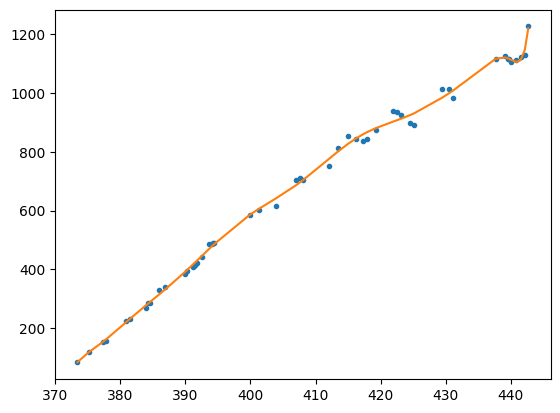

In [67]:
peak_etatau_coeff = np.polyfit(ivytmp_eta[0], ivytmp_eta[1], 70)

poly_etatau = np.poly1d(peak_etatau_coeff)

plt.plot(ivytmp_eta[0], ivytmp_eta[1], '.', ivytmp_eta[0], poly_etatau(ivytmp_eta[0]), '-')
# plt.xlim(360, 410)
# plt.ylim(0, 10.5)

In [68]:
# Given temperature of 20 Tau
Temp_eta_tau = 12558  # K

# Step 1: Generate the blackbody spectrum for 20 Tau
bb_spectrum_etatau = blackbody_spectrum(calibrated_wave, Temp_eta_tau)

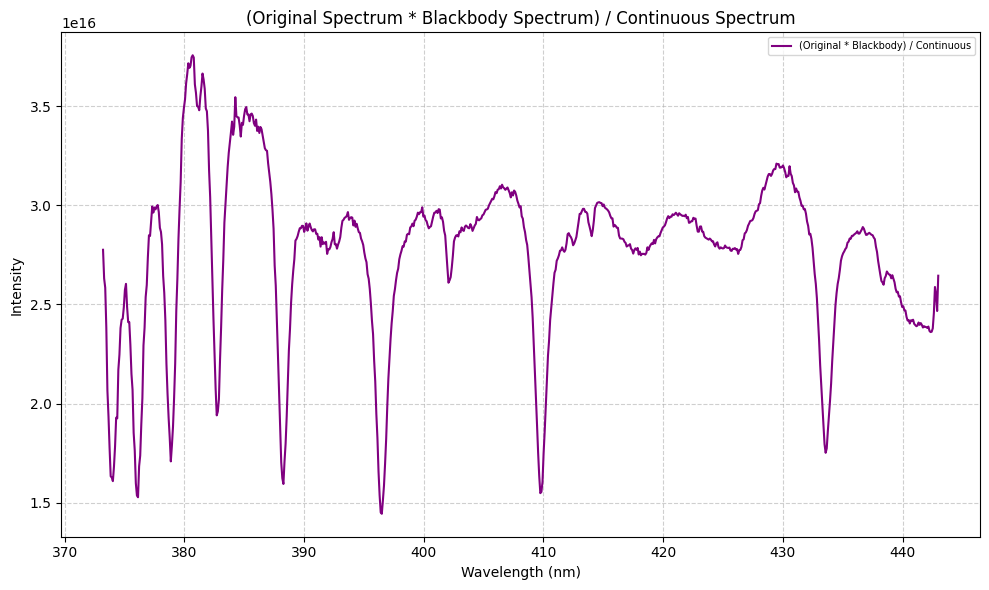

In [69]:
# Calculate the Result: (Original Spectrum * Blackbody Spectrum) / Continuum Spectrum
result_etatau = (master_etatau_1d * bb_spectrum_20tau) / ( poly_20tau(calibrated_wave))


# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(calibrated_wave, result_etatau, label="(Original * Blackbody) / Continuous", color='purple')
plt.title("(Original Spectrum * Blackbody Spectrum) / Continuous Spectrum")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Intensity")
# plt.ylim(-2e15, 2.5e15)
plt.grid(True, linestyle='--', alpha=0.6)

plt.legend(loc='upper right', prop={'size': 7})
plt.tight_layout()
plt.show()

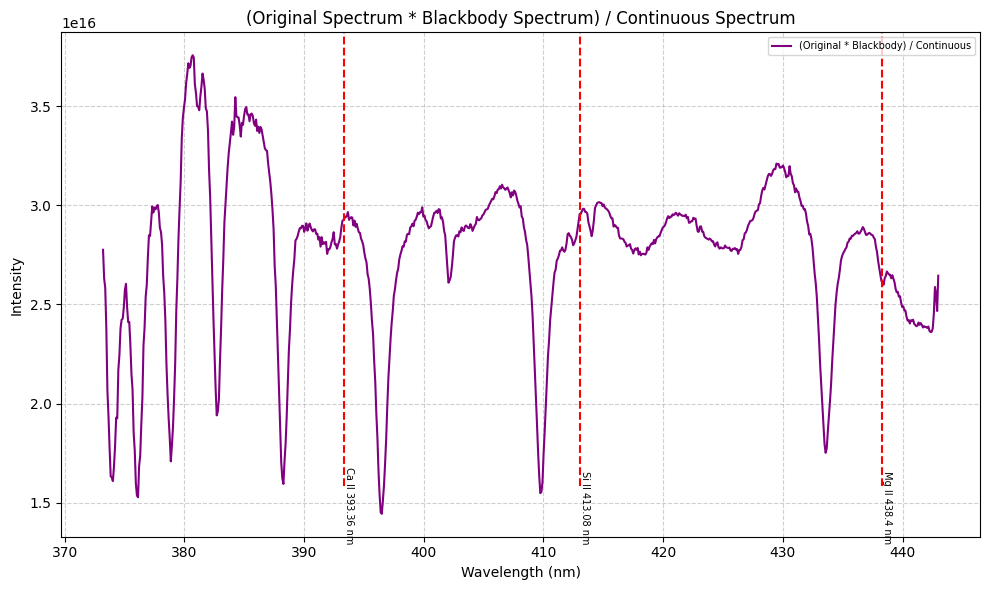

In [70]:
plt.figure(figsize=(10, 6))
plt.plot(calibrated_wave, result_etatau, label="(Original * Blackbody) / Continuous", color='purple')
plt.title("(Original Spectrum * Blackbody Spectrum) / Continuous Spectrum")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Intensity")
#plt.xlim(412, 417)
plt.grid(True, linestyle='--', alpha=0.6)

for i in range(len(maia_wavelength)):
    plt.axvline(x=maia_wavelength[i], ymin=0.1, color='red', linestyle='--')  # Vertical line for each emission line
    plt.text(maia_wavelength[i],1.3e16, f' {maia_dict[i]}',
             fontsize=7, rotation=270, color='black', ha='left')
plt.legend(loc='upper right', prop={'size': 7})
plt.tight_layout()
plt.show()

In [71]:
eta2_peaks_right, _ = find_peaks(result_etatau[410:], prominence=1.3e12)
eta2_peak_right= calibrated_wave[410:][eta2_peaks_right]


eta2_peaks_mid, _ = find_peaks(result_etatau[210:410], prominence=2.6e12)
eta2_peak_mid= calibrated_wave[210:410][eta2_peaks_mid]


eta2_peaks_left, _ = find_peaks(result_etatau[:210], prominence=1e13, height=7e14)
eta2_peak_left= calibrated_wave[:210][eta2_peaks_left]


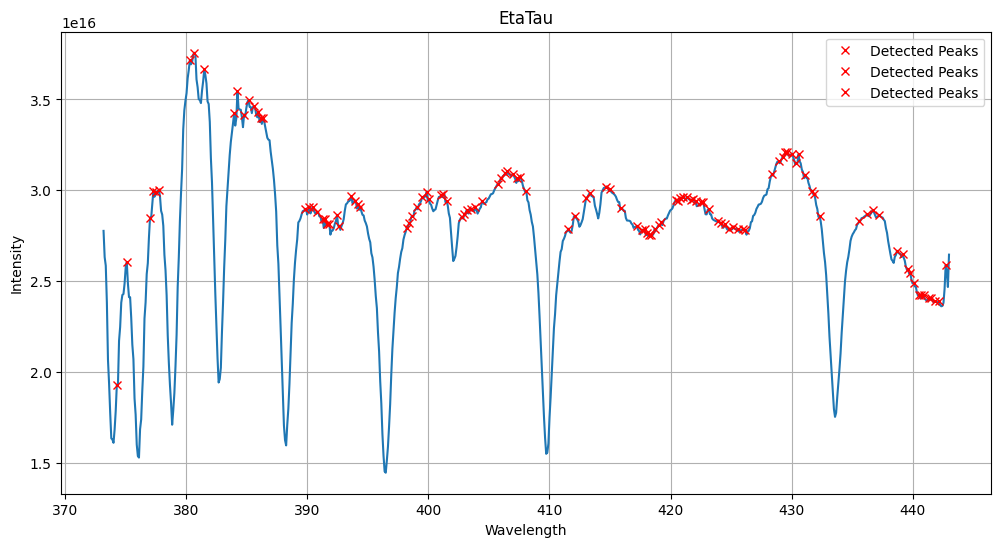

In [72]:
plt.figure(figsize=(12, 6))
plt.plot(calibrated_wave, result_etatau)
plt.plot(calibrated_wave[410:][eta2_peaks_right], result_etatau[410:][eta2_peaks_right], "x", label='Detected Peaks', color='red')
plt.plot(calibrated_wave[210:410][eta2_peaks_mid], result_etatau[210:410][eta2_peaks_mid], "x", label='Detected Peaks', color='red')
plt.plot(calibrated_wave[:210][eta2_peaks_left], result_etatau[:210][eta2_peaks_left], "x", label='Detected Peaks', color='red')
plt.title('EtaTau')
plt.xlabel('Wavelength')
plt.ylabel('Intensity')
plt.legend()
plt.grid()

plt.show()

In [73]:
ivytmp_eta2 = np.column_stack((
    np.row_stack((calibrated_wave[:210][eta2_peaks_left], result_etatau[:210][eta2_peaks_left])),
    np.row_stack((calibrated_wave[210:410][eta2_peaks_mid], result_etatau[210:410][eta2_peaks_mid])),
    np.row_stack((calibrated_wave[410:][eta2_peaks_right], result_etatau[410:][eta2_peaks_right]))
))
ivytmp_eta2

array([[3.74305187e+02, 3.75127080e+02, 3.77044832e+02, 3.77318797e+02,
        3.77501440e+02, 3.77775404e+02, 3.80332407e+02, 3.80697693e+02,
        3.81519586e+02, 3.83985267e+02, 3.84259232e+02, 3.84807161e+02,
        3.85172447e+02, 3.85629055e+02, 3.85994341e+02, 3.86176984e+02,
        3.86359627e+02, 3.89829844e+02, 3.90195130e+02, 3.90469095e+02,
        3.90834381e+02, 3.91290988e+02, 3.91473631e+02, 3.91656274e+02,
        3.91838918e+02, 3.92478168e+02, 3.92660811e+02, 3.93665348e+02,
        3.93939312e+02, 3.94213277e+02, 3.94395920e+02, 3.98231424e+02,
        3.98414067e+02, 3.98688031e+02, 3.99053317e+02, 3.99509925e+02,
        3.99875211e+02, 4.00057854e+02, 4.01062391e+02, 4.01245034e+02,
        4.01518998e+02, 4.02797499e+02, 4.02980142e+02, 4.03162785e+02,
        4.03528071e+02, 4.03893357e+02, 4.04441287e+02, 4.05719788e+02,
        4.05993752e+02, 4.06359038e+02, 4.06541681e+02, 4.06998289e+02,
        4.07363575e+02, 4.07546218e+02, 4.08094147e+02, 4.115643

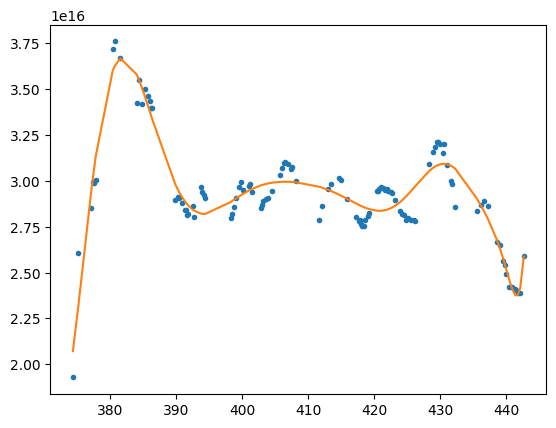

In [74]:
peak_eta2tau_coeff = np.polyfit(ivytmp_eta2[0], ivytmp_eta2[1], 100)

poly_eta2tau = np.poly1d(peak_eta2tau_coeff)

plt.plot(ivytmp_eta2[0], ivytmp_eta2[1], '.', ivytmp_eta2[0], poly_eta2tau(ivytmp_eta2[0]), '-')
# plt.xlim(360, 410)
# plt.ylim(0, 10.5)

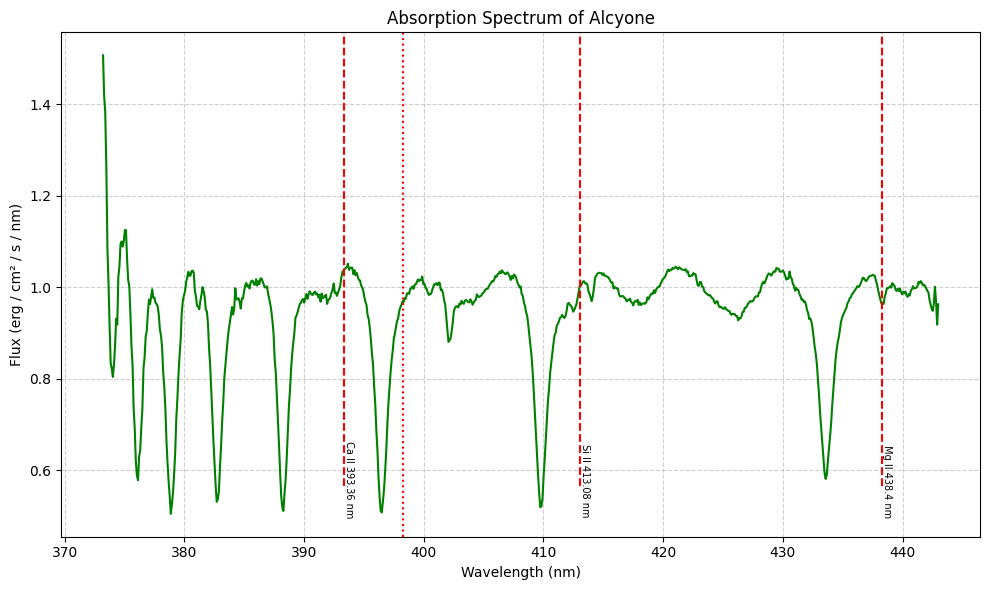

In [75]:
# Calculate the Result: (Original Spectrum * Blackbody Spectrum) / Continuum Spectrum
leveled_etatau = result_etatau  / poly_eta2tau(calibrated_wave)
#result_etatau = (master_etatau_1d / poly_etatau(calibrated_wave)) * bb_spectrum_etatau

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(calibrated_wave, leveled_etatau, label="(Original * Blackbody) / Continuous", color='green')
plt.title("Absorption Spectrum of Alcyone")
plt.xlabel("Wavelength (nm)")
# plt.xlim(390, 405)
plt.ylabel("Flux (erg / cm² / s / nm)")
# plt.ylim(-2e15, 2.5e15)
plt.grid(True, linestyle='--', alpha=0.6)

# Add a vertical dotted line at 398.3 nm
plt.axvline(x=398.3, color='r', linestyle=':', label='398.3 nm')

for i in range(len(maia_wavelength)):
    plt.axvline(x=maia_wavelength[i], ymin=0.1, color='red', linestyle='--')  # Vertical line for each emission line
    plt.text(maia_wavelength[i],0.5, f' {maia_dict[i]}',
             fontsize=7, rotation=270, color='black', ha='left')
#plt.legend()
plt.tight_layout()
plt.show()

# Q Tau

In [76]:
#Open the qtau light frame files and extract the data
raw_qtau=[]

for i in range(10):
    tauq_file = f'{ownerpath}/Lab 3/20tau/pleiades_light/qtau_light_120s_.0000000{i}.FIT'
    tauq_file_data=fits.open(tauq_file)
    raw_qtau.append(tauq_file_data[0].data)

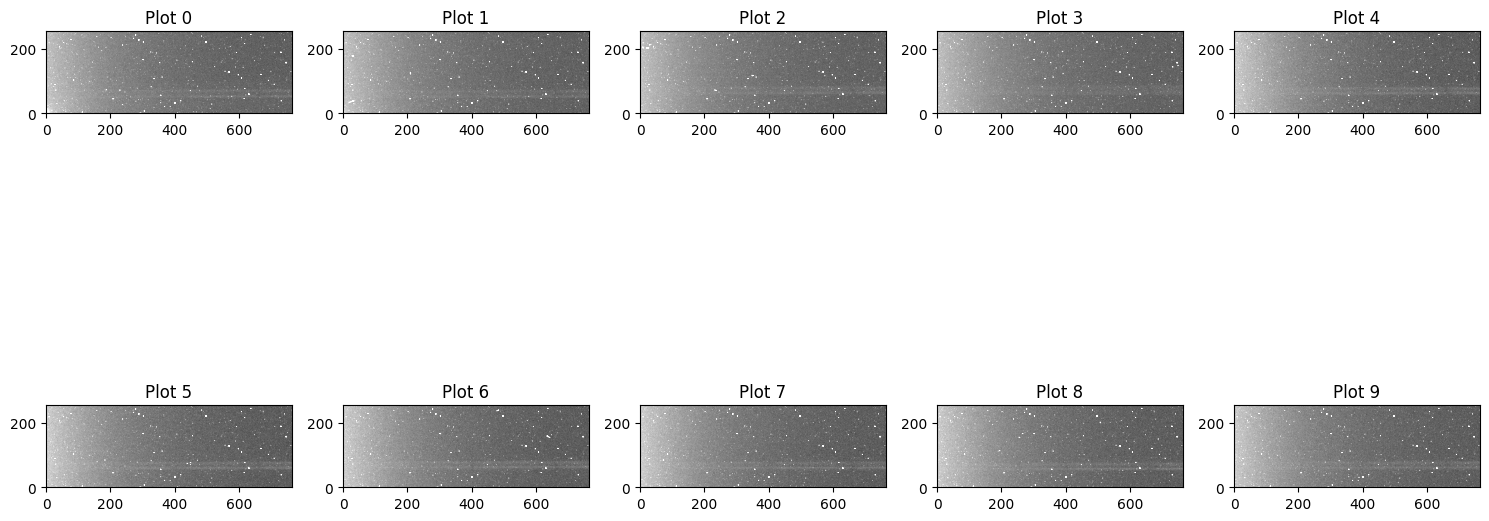

In [77]:
# All 10 light frames of q Tau
fig, axes = plt.subplots(2, 5, figsize=(15, 10))  # 2 rows, 5 columns grid for 10 plots
axes = axes.ravel()  # Flatten the 2D array of axes to make indexing easier

for i in range(10):  # Loop through the 10 indices (0 to 9)
    axes[i].imshow(raw_qtau[i],
                   vmin=np.mean(raw_qtau[i]) - np.std(raw_qtau[i]),
                   vmax=np.mean(raw_qtau[i]) + np.std(raw_qtau[i]),
                   cmap='gray', origin='lower')
    axes[i].set_title(f"Plot {i}")  # Optionally, label each subplot
    #axes[i].axis('off')  # Turn off axis for better visualization

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [78]:
# List to hold the cut data of each corrected Q Tau frame
qtau_cut = []

# Define the y-axis ranges for each frame
y_ranges_qtau = [(46, 76), (45, 75), (56, 86), (57, 87), (54, 84),
                 (52, 82), (54, 84), (53, 83), (48, 78), (52, 82)]

# Loop through each corrected frame, cut along y-axis, and extract the data
for i in range(10):
    # Get the full frame data
    frame_data = raw_qtau[i]

    # Cut the frame data along the y-axis according to the specified range
    y_start, y_end = y_ranges_qtau[i]
    cut_frame_data = frame_data[y_start:y_end, :]

    # Append the cut frame data to the list
    qtau_cut.append(cut_frame_data)

In [79]:
darksubtracted_qtau = []
for i in range(10):
    dark_sub=qtau_cut[i]-darks_qtau_cut[i]
    darksubtracted_qtau.append(dark_sub)

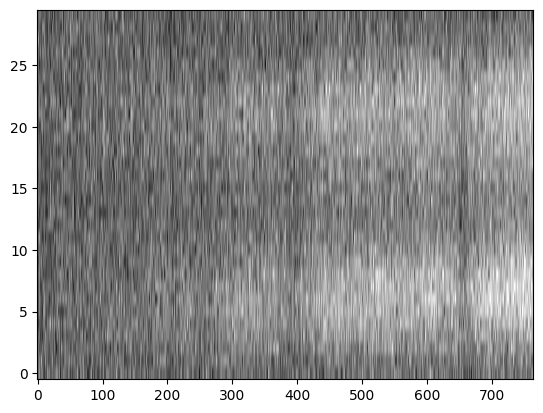

In [80]:
master_qtau = (np.median(darksubtracted_qtau, axis=0))
master_qtau_sum = (np.sum(darksubtracted_qtau, axis=0))

plt.imshow(master_qtau, cmap='gray',
           vmin=np.mean(master_qtau) - (3 * np.std(master_qtau)),
           vmax=np.mean(master_qtau) + (3 * np.std(master_qtau)), aspect='auto', origin='lower')

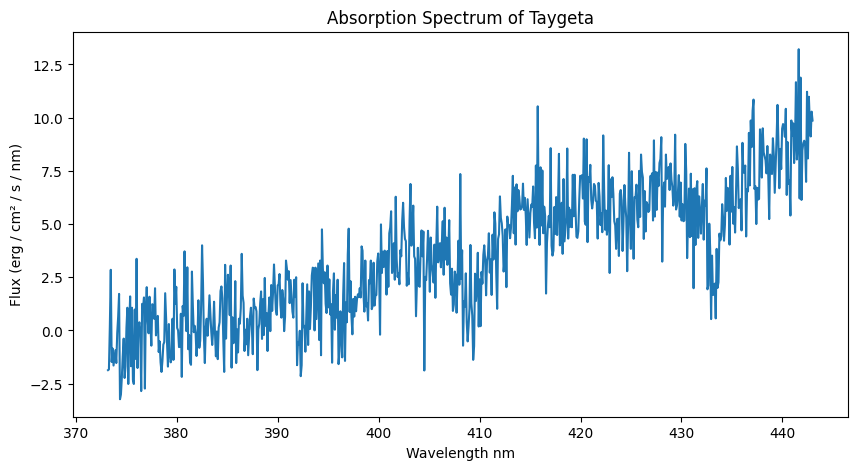

In [81]:
# Step 1: Sum along the y-axis for each mercury frame
master_qtau_1d= np.mean(master_qtau, axis=0)
master_qtau_1d_sum= np.mean(master_qtau_sum, axis=0)

# Step 3: Plot the averaged mercury spectrum
plt.figure(figsize=(10, 5))
plt.plot(calibrated_wave, master_qtau_1d)
#plt.plot(calibrated_wave, master_qtau_1d_sum/10)
plt.title("Absorption Spectrum of Taygeta")
plt.xlabel("Wavelength nm")
plt.ylabel("Flux (erg / cm² / s / nm)")
plt.show()

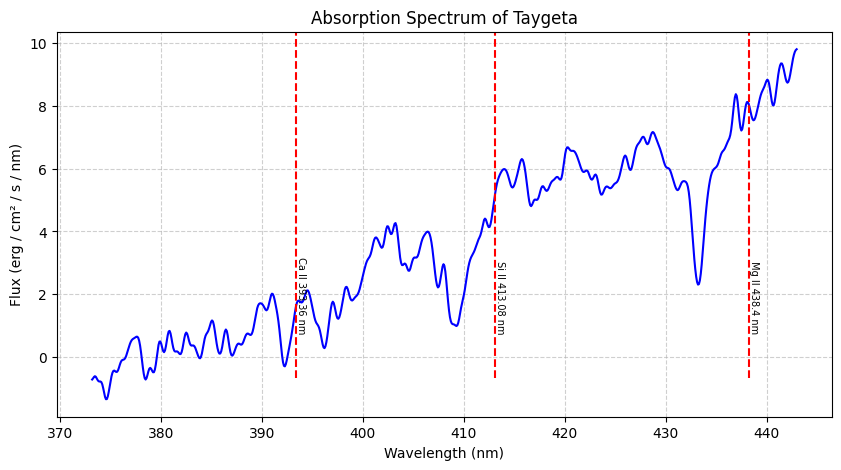

In [82]:
from scipy.ndimage import gaussian_filter1d

# Step 1: Sum along the y-axis for each mercury frame
master_qtau_1d = np.mean(master_qtau, axis=0)
master_qtau_1d_sum = np.mean(master_qtau_sum, axis=0)

# Step 2: Apply Gaussian smoothing to the spectrum
smoothed_qtau_1d = gaussian_filter1d(master_qtau_1d, sigma=3)  # Adjust sigma for more/less smoothing

# Step 3: Plot the averaged and smoothed mercury spectrum
plt.figure(figsize=(10, 5))
plt.plot(calibrated_wave, smoothed_qtau_1d, label="Smoothed Spectrum", color='blue')
#plt.plot(calibrated_wave, master_qtau_1d, label="Original Spectrum", color='gray', alpha=0.5, linestyle='--')
plt.title("Absorption Spectrum of Taygeta")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Flux (erg / cm² / s / nm)")
#plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
# Vertical lines and annotations for emission lines
for i in range(len(maia_wavelength)):
    plt.axvline(x=maia_wavelength[i], ymin=0.1, color='red', linestyle='--')  # Vertical line for each emission line
    plt.text(maia_wavelength[i], 0.8, f' {maia_dict[i]}', fontsize=7, rotation=270, color='black', ha='left')

plt.show()

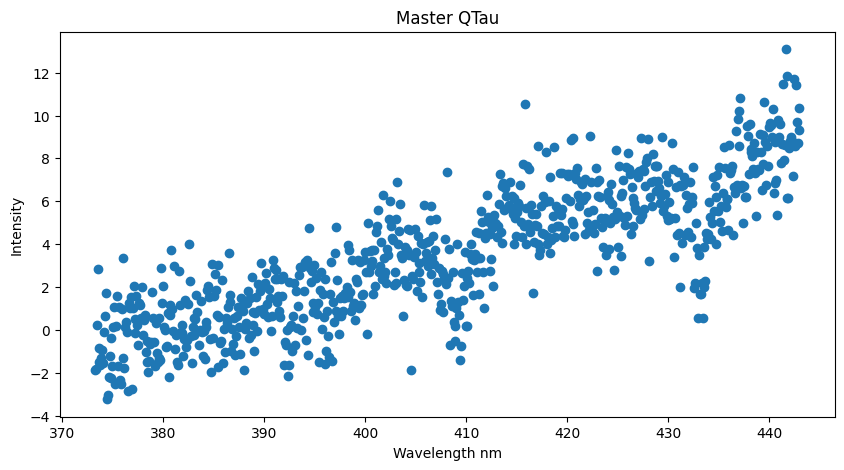

In [83]:
norm_master_qtau = master_qtau_1d/normalized_flat

plt.figure(figsize=(10, 5))
plt.scatter(calibrated_wave, norm_master_qtau)
#plt.plot(calibrated_wave, master_qtau_1d)
plt.title("Master QTau")
plt.xlabel("Wavelength nm")
plt.ylabel("Intensity")
# plt.xlim(420, 445)
# plt.ylim(-100, 500)
plt.show()

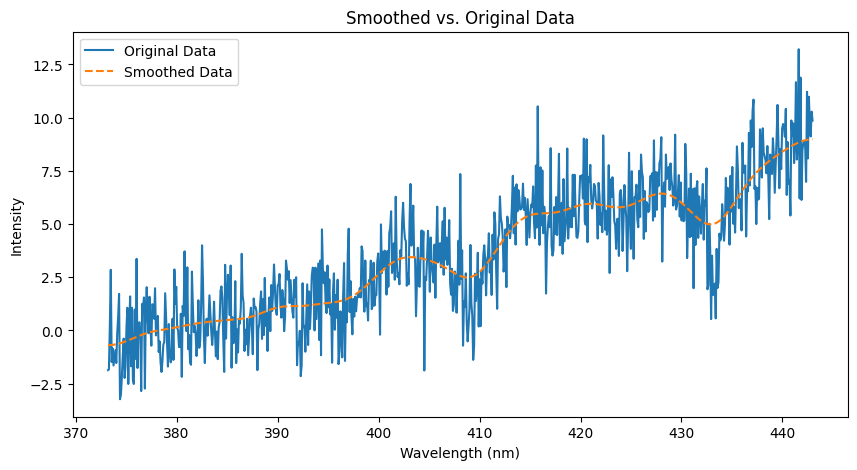

In [84]:
from scipy.ndimage import gaussian_filter1d

# Smooth the data (sigma controls the width of the smoothing filter)
smoothed_data = gaussian_filter1d(master_qtau_1d, sigma=20)

# Plot the smoothed data to visualize the underlying signal
plt.figure(figsize=(10, 5))
plt.plot(calibrated_wave, master_qtau_1d, label="Original Data")
plt.plot(calibrated_wave, smoothed_data, label="Smoothed Data", linestyle="--")
plt.title("Smoothed vs. Original Data")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Intensity")
plt.legend()
plt.show()

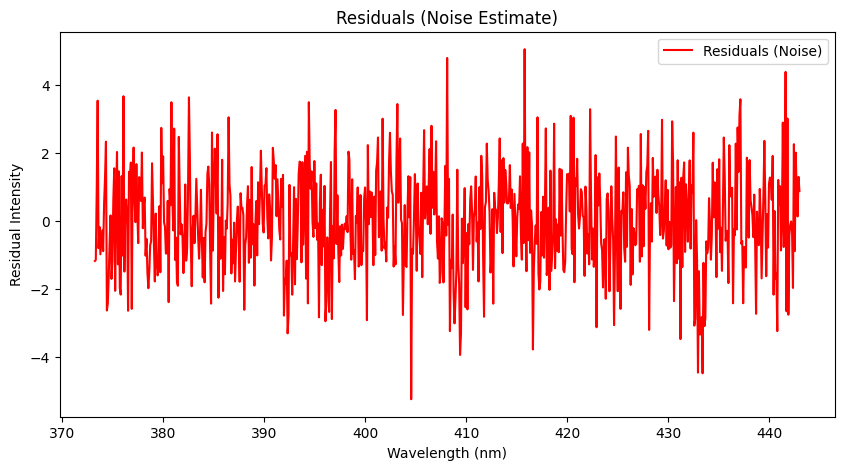

Estimated Noise Standard Deviation: 1.48


In [85]:
# Calculate the residuals (difference between original and smoothed data)
residuals = master_qtau_1d - smoothed_data

# Plot the residuals (showing the noise)
plt.figure(figsize=(10, 5))
plt.plot(calibrated_wave, residuals, label="Residuals (Noise)", color='red')
plt.title("Residuals (Noise Estimate)")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Residual Intensity")
plt.legend()
plt.show()

# Calculate the standard deviation of the residuals (estimate of the noise)
noise_std = np.std(residuals)
print(f"Estimated Noise Standard Deviation: {noise_std:.2f}")

In [86]:
# Estimate the signal level by calculating the mean of the smoothed data
signal_mean = np.mean(smoothed_data)
print(f"Estimated Signal Mean: {signal_mean:.2f}")

Estimated Signal Mean: 3.55


In [87]:
# Calculate SNR (Signal divided by Noise)
snr = signal_mean / noise_std
print(f"Signal-to-Noise Ratio: {snr:.2f}")

# Interpret SNR
if snr < 3:
    print("The SNR is between 2-3, indicating that the object is barely detected.")
elif snr < 5:
    print("The SNR is between 3-5, suggesting the object is detected, but with low clarity.")
elif snr < 10:
    print("The SNR is between 5-10, meaning the object is detected, and one can really start to believe what one sees.")
else:
    print("The SNR is greater than 10, indicating we can start to do measurements.")

#Source: https://www.eso.org/~ohainaut/ccd/sn.html#:~:text=%2D%20Signal%2Dto%2DNoise%20Ratio,to%20beleive%20what%20one%20sees

Signal-to-Noise Ratio: 2.41
The SNR is between 2-3, indicating that the object is barely detected.


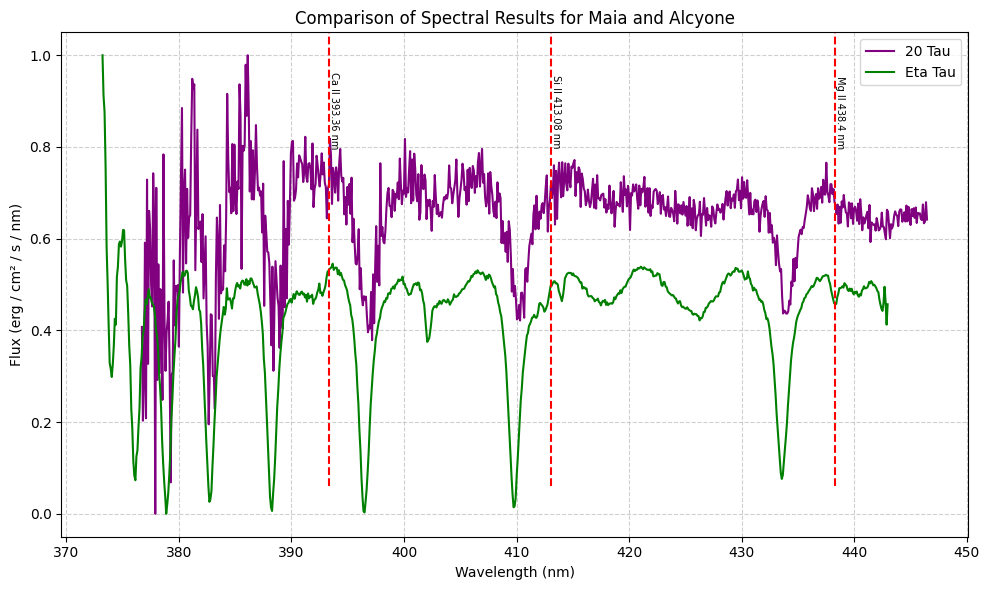

In [88]:
# Normalize the y-axis values
norm_result_20tau = (result_20tau - result_20tau.min()) / (result_20tau.max() - result_20tau.min())
norm_leveled_etatau = (leveled_etatau - leveled_etatau.min()) / (leveled_etatau.max() - leveled_etatau.min())

# Plotting both results on the same graph
plt.figure(figsize=(10, 6))
plt.plot(calibrated_wave + 3.5, norm_result_20tau, label="20 Tau", color='purple')
plt.plot(calibrated_wave, norm_leveled_etatau, label="Eta Tau", color='green')

# Add titles, labels, and legends
plt.title("Comparison of Spectral Results for Maia and Alcyone")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Flux (erg / cm² / s / nm)")
plt.grid(True, linestyle='--', alpha=0.6)

# Vertical lines and annotations for emission lines
for i in range(len(maia_wavelength)):
    plt.axvline(x=maia_wavelength[i], ymin=0.1, color='red', linestyle='--')  # Vertical line for each emission line
    plt.text(maia_wavelength[i], 0.8, f' {maia_dict[i]}', fontsize=7, rotation=270, color='black', ha='left')

# Add legend and layout
plt.legend()
plt.tight_layout()
plt.show()

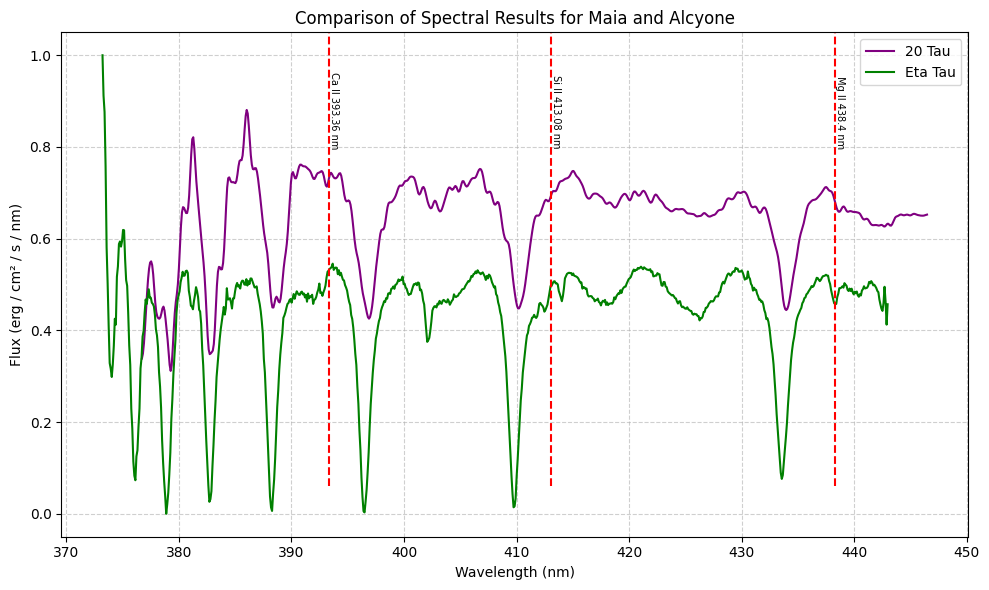

In [89]:
from scipy.ndimage import gaussian_filter1d

# Apply Gaussian smoothing to the 20 Tau result
smoothed_result_20tau = gaussian_filter1d(norm_result_20tau, sigma=2)  # Adjust sigma for more/less smoothing

# Plotting both results on the same graph
plt.figure(figsize=(10, 6))
plt.plot(calibrated_wave + 3.5, smoothed_result_20tau, label="20 Tau", color='purple')
plt.plot(calibrated_wave, norm_leveled_etatau, label="Eta Tau", color='green')

# Add titles, labels, and legends
plt.title("Comparison of Spectral Results for Maia and Alcyone")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Flux (erg / cm² / s / nm)")
plt.grid(True, linestyle='--', alpha=0.6)

# Vertical lines and annotations for emission lines
for i in range(len(maia_wavelength)):
    plt.axvline(x=maia_wavelength[i], ymin=0.1, color='red', linestyle='--')  # Vertical line for each emission line
    plt.text(maia_wavelength[i], 0.8, f' {maia_dict[i]}', fontsize=7, rotation=270, color='black', ha='left')

# Add legend and layout
plt.legend()
plt.tight_layout()
plt.show()